#### Initial setups

In [1]:
!pip3 install imageio
!pip3 install matplotlib
!pip3 install scikit-image
!pip3 install scikit-learn

You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.1, however version 19.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
#importing the libraries used in the rest of hte code
import os
import gzip
import shutil
import tarfile
import imageio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile
import collections
from skimage import morphology
from skimage.measure import block_reduce
import scipy
from torch.utils.data import Dataset
import PIL
from PIL import Image
from sklearn.metrics import f1_score
import copy
import random
import math
import torch

In [3]:
#checking what kind of system you are using
try:
  import google.colab
  from google.colab import drive
  from google.colab import files
  IN_COLAB = True
except:
  IN_COLAB = False
try:
    hostname = !hostname
    if 'lab' in hostname[0] and '.eng.utah.edu' in hostname[0]:
        IN_CADE = True
    else:
        IN_CADE = False
except:
    IN_CADE = False

assert(not IN_CADE or not IN_COLAB)

In [4]:
# with this function you set the value of the environment variable CUDA_VISIBLE_DEVICES
# to set which GPU to use
# it also reserves this amount of memory for your exclusive use. This might be important for 
# not having other people using the resources you need in shared systems
# the homework was tested in a GPU with 4GB of memory, and running this function will require at least
# as much
# if you want to test in a GPU with less memory, you can call this function
# with the argument minimum_memory_mb specifying how much memory from the GPU you want to reserve
def define_gpu_to_use(minimum_memory_mb = 3800):
    gpu_to_use = None
    try: 
        os.environ['CUDA_VISIBLE_DEVICES']
        print('GPU already assigned before: ' + str(os.environ['CUDA_VISIBLE_DEVICES']))
        return
    except:
        pass
    torch.cuda.empty_cache()
    for i in range(16):
        free_memory = !nvidia-smi --query-gpu=memory.free -i $i --format=csv,nounits,noheader
        if free_memory[0] == 'No devices were found':
            break
        free_memory = int(free_memory[0])
        if free_memory>minimum_memory_mb-500:
            gpu_to_use = i
            break
    if gpu_to_use is None:
        print('Could not find any GPU available with the required free memory of ' +str(minimum_memory_mb) + 'MB. Please use a different system for this assignment.')
    else:
        os.environ['CUDA_VISIBLE_DEVICES'] = str(gpu_to_use)
        print('Chosen GPU: ' + str(gpu_to_use))
        x = torch.rand((256,1024,minimum_memory_mb-500)).cuda()
        x = torch.rand((1,1)).cuda()
        del x

In [5]:
if IN_CADE:
    #setting the gpu that will be used, testing if it has enough available memory, and reserving the needed memory
    define_gpu_to_use()

#### Defining functions used to load the dataset

We are going to use datasets of retinal digital images and segment the blood vessels from it. We are going to use the DRIVE dataset (https://www.isi.uu.nl/Research/Databases/DRIVE/) and the STARE dataset (http://cecas.clemson.edu/~ahoover/stare/) together in this assignment. We are going to use our own train/validation/test splits, even though the DRIVE dataset provides its own split. Please download the files named "DRIVE.zip" (register in https://www.isi.uu.nl/Research/Databases/DRIVE/download.php and follow the instructions), "stare-images.tar" (http://cecas.clemson.edu/~ahoover/stare/probing/stare-images.tar), "labels-vk.tar" (http://cecas.clemson.edu/~ahoover/stare/probing/labels-vk.tar) and put in the same folder as this notebook file so that the dataset can be loaded. 

The dataset also contains masks since the images are not shaped as squares originally, but are only padded so that we can fit them to a traditional CNN. The masks contain the information of where the original image is and where the padding is located. These masks should be used to limit where outputs are backpropagated for training and what region of the image should be used for scoring. In the mask, 1 means that it is part of the original image, and 0 means that it in the zero-padded region.

In [6]:
#delete small regions (<size) of binary images
def remove_small_regions(img, size):
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

In [7]:
#resize the images of the dataset to be half the height and half the width of the original images, so 
# that models states can fit on the GPU memory
def resize_img(img):
    if len(img.shape)==3:
        img = np.array(Image.fromarray(img).resize(((img.shape[1]+1)//2,(img.shape[0]+1)//2), PIL.Image.BILINEAR))
    else:
        img = block_reduce(img, block_size=(2, 2), func=np.max)
    return img

In [8]:
#unzips, loads and calculates masks for images from the stare dataset
def stare_read_images(tar_filename, dest_folder, do_mask = False):
    #tar = tarfile.open(tar_filename)
    #tar.extractall(dest_folder)
    #tar.close()
    all_images = []
    all_masks = []
    for item in sorted(os.listdir(dest_folder)):
        if item.endswith('gz'):
            with gzip.open(dest_folder + item, 'rb') as f_in:
                with open(dest_folder + item[:-3], 'wb') as f_out:
                    shutil.copyfileobj(f_in, f_out)
            os.remove(dest_folder + item) 
            img = imageio.imread(dest_folder + item[:-3])
            if len(img.shape) == 3:
                img = np.pad(img , ((1,2), (2,2),(0,0)), mode = 'constant')
            else:
                img = np.pad(img , ((1,2), (2,2)), mode = 'constant')
            img = resize_img(img)
            img = img/255.
            img = img.astype(np.float32)
            if len(img.shape) == 2:
                img = img.astype(np.float32)
                img = np.expand_dims(img, axis = 2)
            all_images.append(img)
            if do_mask:
                mask = (1-remove_small_regions(np.prod((img<50/255.)*1.0, axis = 2)>0.5, 1000))*1.0
                mask = np.expand_dims(mask, axis = 2)
                all_masks.append(mask.astype(np.float32))
    if do_mask:
        return all_images, all_masks
    else:
        return all_images

In [9]:
#unzips and loads masks for images from the stare dataset
def drive_read_images(filetype, dest_folder):
    #zip_ref = zipfile.ZipFile('DRIVE.zip', 'r')
    #zip_ref.extractall('datasets/drive')
    #zip_ref.close()
    all_images = []
    for item in sorted(os.listdir(dest_folder)):
        if item.endswith(filetype):
            img = imageio.imread(dest_folder + item)
            if len(img.shape) == 3:
                img = np.pad(img , ((12,12), (69,70),(0,0)), mode = 'constant')
            else:
                img = np.pad(img , ((12,12), (69,70)), mode = 'constant')
            img = resize_img(img)
            img = img/255.
            img = img.astype(np.float32)
            if len(img.shape) == 2:
                img = img.astype(np.float32)
                img = np.expand_dims(img, axis = 2)
            all_images.append(img)
    return all_images

In [10]:
#load all images and put them on a list of list of arrays.
# on the inner lists, first element is an input image, second element is a segmentation groundtruth
# and third element is a mask to show where the input image is valid, in contrast to where it was padded

number_persistence_vals = 6
def get_retina_array(partial = True):
    stare_images, stare_mask = stare_read_images("stare-images.tar", 'datasets/stare/images/', do_mask = True)            
    stare_segmentation = stare_read_images("labels-vk.tar", 'datasets/stare/segmentations/')   
    drive_training_images = drive_read_images('tif', 'datasets/drive/DRIVE/training/images/')
    drive_training_mask = drive_read_images('gif', 'datasets/drive/DRIVE/training/mask/')
    drive_test_images = drive_read_images('tif', 'datasets/drive/DRIVE/test/images/')
    
    true_segmentation = drive_read_images('gif', 'datasets/drive/DRIVE/training/1st_manual/')
    
    for i in range(number_persistence_vals):
        stare_mask += stare_mask
        stare_images += stare_images
        drive_training_images += drive_training_images
        drive_training_mask += drive_training_mask
        true_segmentation += true_segmentation
        
    drive_training_segmentation_msc_pers_7 = drive_read_images('tif', 'datasets/drive/DRIVE/train_MSC_seg/persistence_7/')#1st_manual/')    
    drive_training_segmentation_msc_pers_10 = drive_read_images('tif', 'datasets/drive/DRIVE/train_MSC_seg/persistence_10/')#1st_manual/')    
    drive_training_segmentation_msc_pers_12 = drive_read_images('tif', 'datasets/drive/DRIVE/train_MSC_seg/persistence_12/')#1st_manual/')
    drive_training_segmentation_msc_pers_15 = drive_read_images('tif', 'datasets/drive/DRIVE/train_MSC_seg/persistence_15/')
    drive_training_segmentation_msc_pers_20 = drive_read_images('tif', 'datasets/drive/DRIVE/train_MSC_seg/persistence_20/')
    drive_training_segmentation_msc_pers_23 = drive_read_images('tif', 'datasets/drive/DRIVE/train_MSC_seg/persistence_23/')
    drive_training_segmentation_msc_pers_25 = drive_read_images('tif', 'datasets/drive/DRIVE/train_MSC_seg/persistence_25/')
    drive_training_segmentation_msc_pers_30 = drive_read_images('tif', 'datasets/drive/DRIVE/train_MSC_seg/persistence_30/')
    
    drive_training_segmentation = drive_training_segmentation_msc_pers_7 + drive_training_segmentation_msc_pers_10 + drive_training_segmentation_msc_pers_12  + drive_training_segmentation_msc_pers_15 + drive_training_segmentation_msc_pers_20 + drive_training_segmentation_msc_pers_23
    all_drive_msc_seg = drive_training_segmentation_msc_pers_7 + drive_training_segmentation_msc_pers_10 + drive_training_segmentation_msc_pers_12  + drive_training_segmentation_msc_pers_15 + drive_training_segmentation_msc_pers_20 + drive_training_segmentation_msc_pers_23  + drive_training_segmentation_msc_pers_30 #+ drive_training_segmentation_msc_pers_25 
    #
    
    stare_training_segmentation_msc_pers_7 = stare_read_images('tif', 'datasets/stare/stare_msc_seg/persistence_7/')#1st_manual/')    
    stare_training_segmentation_msc_pers_10 = stare_read_images('tif', 'datasets/stare/stare_msc_seg/persistence_10/')#1st_manual/')    
    stare_training_segmentation_msc_pers_12 = stare_read_images('tif', 'datasets/stare/stare_msc_seg/persistence_12/')#1st_manual/')
    stare_training_segmentation_msc_pers_15 = stare_read_images('tif', 'datasets/stare/stare_msc_seg/persistence_15/')
    stare_training_segmentation_msc_pers_20 = stare_read_images('tif', 'datasets/stare/stare_msc_seg/persistence_20/')
    stare_training_segmentation_msc_pers_23 = stare_read_images('tif', 'datasets/stare/stare_msc_seg/persistence_23/')
    stare_training_segmentation_msc_pers_25 = stare_read_images('tif', 'datasets/stare/stare_msc_seg/persistence_25/')
    stare_training_segmentation_msc_pers_30 = stare_read_images('tif', 'datasets/stare/stare_msc_seg/persistence_30/')
    
    stare_training_segmentation =  stare_training_segmentation_msc_pers_7 + stare_training_segmentation_msc_pers_10 +   stare_training_segmentation_msc_pers_12 + stare_training_segmentation_msc_pers_15 + stare_training_segmentation_msc_pers_20 + stare_training_segmentation_msc_pers_23 
    
    all_stare_msc_seg =  stare_training_segmentation_msc_pers_7 + stare_training_segmentation_msc_pers_10 +   stare_training_segmentation_msc_pers_12 + stare_training_segmentation_msc_pers_15 + stare_training_segmentation_msc_pers_20 + stare_training_segmentation_msc_pers_23  + stare_training_segmentation_msc_pers_30 #+ stare_training_segmentation_msc_pers_25 
    #stare_training_segmentation_msc_pers_10 + stare_training_segmentation_msc_pers_12 
    
    total_msc_segmentation = stare_training_segmentation +  drive_training_segmentation 
    
    # hand draw ground truth
    drive_test_segmentation = drive_read_images('gif', 'datasets/drive/DRIVE/test/1st_manual/')
    drive_test_mask = drive_read_images('gif', 'datasets/drive/DRIVE/test/mask/')
    if partial:
        return list(zip(stare_images+drive_training_images+drive_test_images, 
                           total_msc_segmentation+drive_test_segmentation, 
                           stare_mask + drive_training_mask + drive_test_mask))
    else:
        return list(zip(stare_images+drive_training_images+drive_test_images, 
                           total_msc_segmentation+drive_test_segmentation, 
                           stare_mask + drive_training_mask + drive_test_mask,
                       stare_segmentation + true_segmentation+drive_test_segmentation))

In [11]:
#split can be 'train', 'val', and 'test'
#this is the function that splits a dataset into training, validation and testing set
#We are using a split of 70%-10%-20%, for train-val-test, respectively
#this function is used internally to the defined dataset classes
def get_split(array_to_split, split):
    np.random.seed(0)
    np.random.shuffle(array_to_split)
    np.random.seed()
    if split == 'train':
        array_to_split = array_to_split[:int(len(array_to_split)*0.7)]
    elif split == 'val':
        array_to_split = array_to_split[int(len(array_to_split)*0.7):int(len(array_to_split)*0.8)]
    elif split == 'test':
        array_to_split = array_to_split[int(len(array_to_split)*0.8):]
    return array_to_split

In [12]:
#for segmentations tasks, the exact transformations that are applied to 
# the input image should be applied, down to the random number used, should
# also be applied to the ground truth and to the masks. We redefine a few of
# PyTorch classes 

#apply transoforms to all tensors in list x 
def _iterate_transforms(transform, x):
    for i, xi in enumerate(x):
        x[i] = transform(x[i])
    return x

#redefining composed transform so that it uses the _iterate_transforms function
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, x):
        for transform in self.transforms:
            x = _iterate_transforms(transform, x) 
        return x

#class to rerandomize the vertical flip transformation   
class RandomVerticalFlipGenerator(object):
    def __call__(self, img):
        self.random_n = random.uniform(0, 1)
        return img

#class to perform vertical flip using randomization provided by gen
class RandomVerticalFlip(object):
    def __init__(self, gen):
        self.gen = gen

    def __call__(self, img):
        if self.gen.random_n < 0.5:
            return torch.flip(img, [2])
        return img

#class to rerandomize the horizontal flip transformation   
class RandomHorizontalFlipGenerator(object):
    def __call__(self, img):
        self.random_n = random.uniform(0, 1)
        return img

#class to perform horizontal flip using randomization provided by gen
class RandomHorizontalFlip(object):
    def __init__(self, gen):
        self.gen = gen

    def __call__(self, img):
        if self.gen.random_n < 0.5:
            return torch.flip(img, [1])
        return img 

In [13]:
#Dataset class for the retina dataset
# each item of the dataset is a tuple with three items:
# - the first element is the input image to be segmented 
# - the second element is the segmentation ground truth image 
# - the third element is a mask to know what parts of the input image should be used (for training and for scoring)
class RetinaDataset(Dataset):
    def transpose_first_index(self, x, with_hand_seg = False):
        if not with_hand_seg:
            x2 = (np.transpose(x[0], [2,0,1]), np.transpose(x[1], [2,0,1]), np.transpose(x[2], [2,0,1]))
        else:
            x2 = (np.transpose(x[0], [2,0,1]), np.transpose(x[1], [2,0,1]), np.transpose(x[2], [2,0,1]), np.transpose(x[3], [2,0,1]))
        return x2
    
    def __init__(self, retina_array, split = 'train', do_transform=False, with_hand_seg = False):
        self.with_hand_seg = with_hand_seg
        indexes_this_split = get_split(np.arange(len(retina_array), dtype = np.int), split)
        self.retina_array = [self.transpose_first_index(retina_array[i], self.with_hand_seg) for i in indexes_this_split]
        self.split = split
        self.do_transform = do_transform
    def __getitem__(self, index):
        sample = [torch.FloatTensor(x) for x in self.retina_array[index]]
        if self.do_transform:
            v_gen = RandomVerticalFlipGenerator()
            h_gen = RandomHorizontalFlipGenerator()
            t = Compose([
                v_gen,
                RandomVerticalFlip(gen=v_gen),
                h_gen,
                RandomHorizontalFlip(gen=h_gen),
            ])
            sample = t(sample)
        return sample
    
    def __len__(self):
        return len(self.retina_array)

#### Loading and visualizing the dataset

In [14]:

retina_array = get_retina_array()

retina_array_full = get_retina_array(partial = False)

#datase to use for training:
train_dataset = RetinaDataset(retina_array, do_transform = True)
#dataset to use for validation
val_dataset = RetinaDataset(retina_array, split = 'val')
#dataset to use for testing
test_dataset = RetinaDataset(retina_array, split = 'test')

/usr/local/lib/python3.5/dist-packages/imageio/plugins/_tifffile.py:8388: UserWarning: unexpected end of LZW stream (code 0)
  warnings.warn('unexpected end of LZW stream (code %i)' % code)


/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


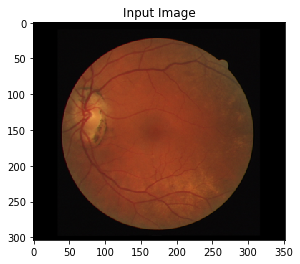

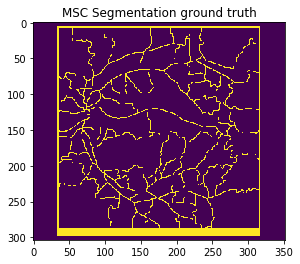

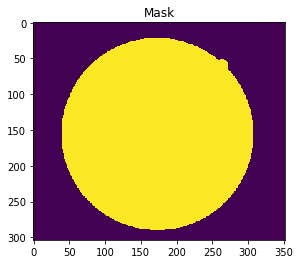

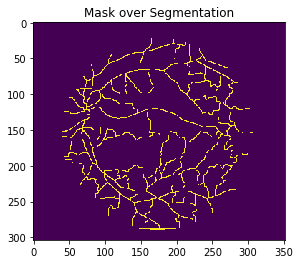

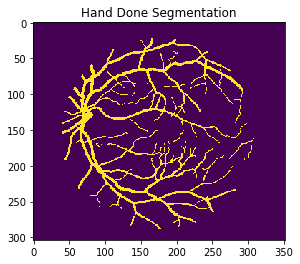

<Figure size 432x288 with 0 Axes>

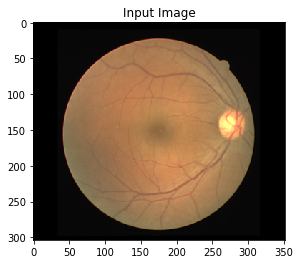

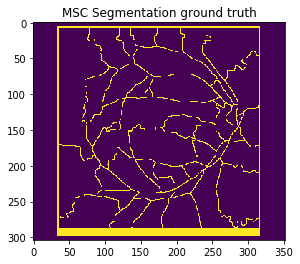

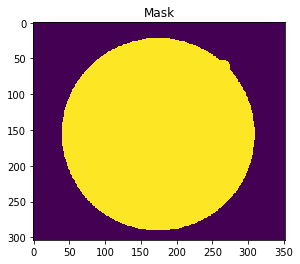

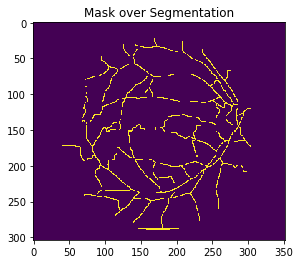

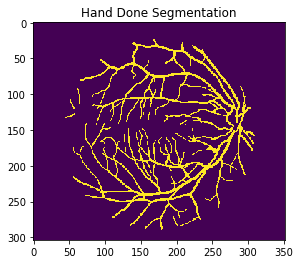

<Figure size 432x288 with 0 Axes>

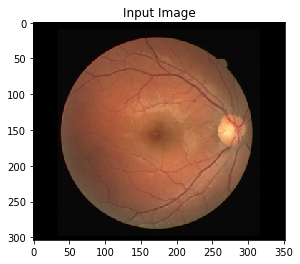

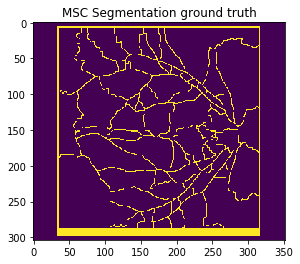

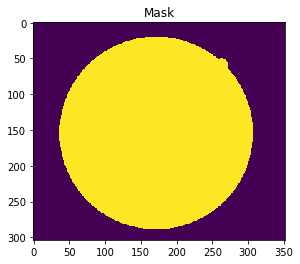

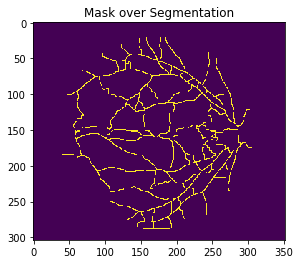

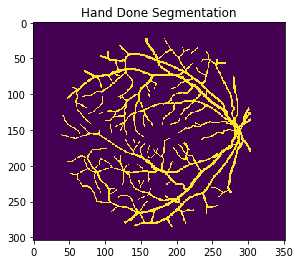

<Figure size 432x288 with 0 Axes>

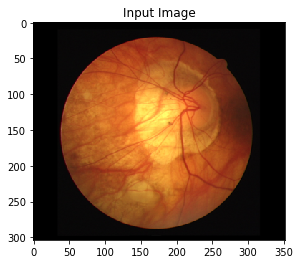

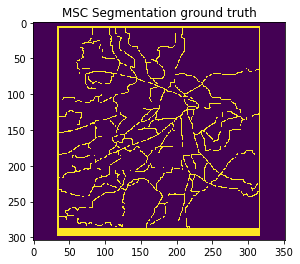

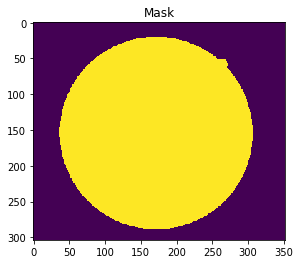

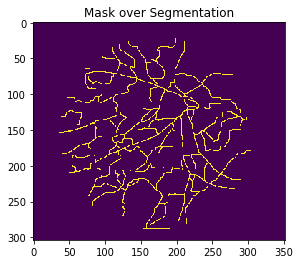

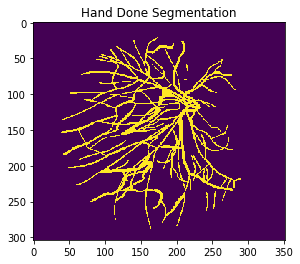

<Figure size 432x288 with 0 Axes>

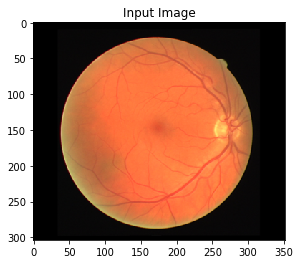

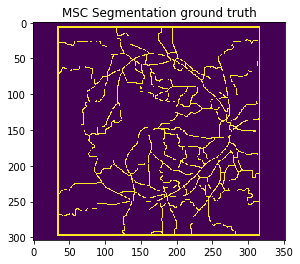

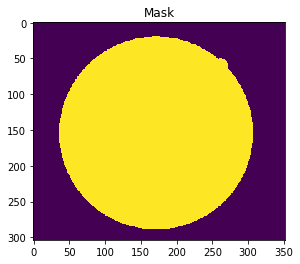

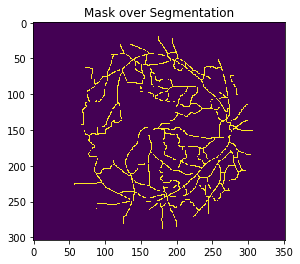

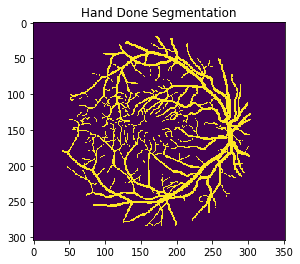

<Figure size 432x288 with 0 Axes>

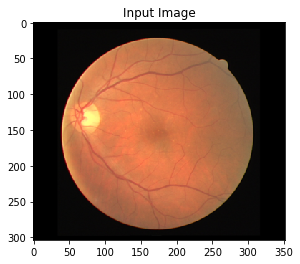

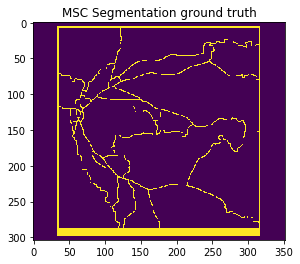

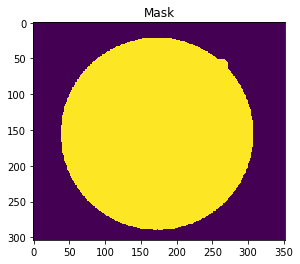

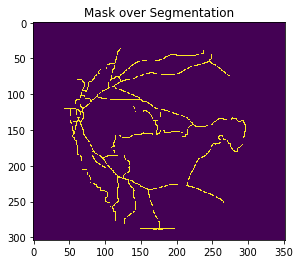

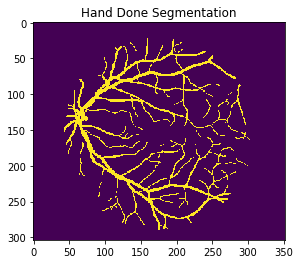

<Figure size 432x288 with 0 Axes>

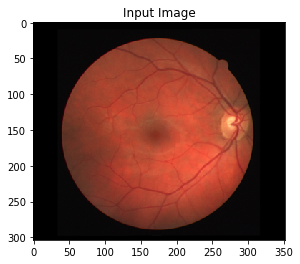

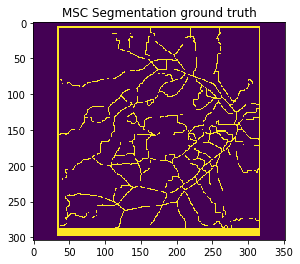

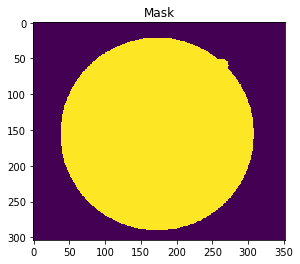

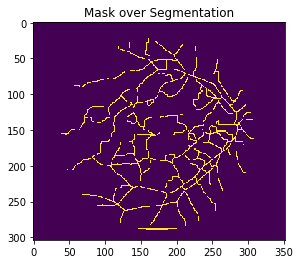

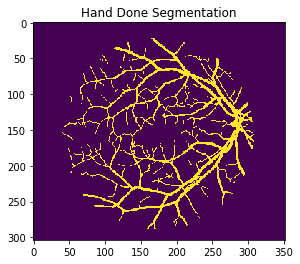

<Figure size 432x288 with 0 Axes>

In [15]:
#Visualing a few cases in the training set
for batch_idx, (data, segmentation, mask, hand_seg) in enumerate( RetinaDataset(retina_array_full, with_hand_seg = True)):
    if batch_idx%15 == 0: 
        plt.figure()
        plt.title("Input Image")
        plt.imshow(data[:,:,:].permute([1,2,0]).cpu().numpy())
        plt.figure()
        plt.title("MSC Segmentation ground truth")
        segmentation[segmentation > 0] = 1
        masked_seg = mask*segmentation
        plt.imshow(segmentation[0,:,:].cpu().numpy())
        plt.figure()
        plt.title("Mask") 
        plt.imshow(mask[0,:,:].cpu().numpy())
        plt.figure()
        plt.title("Mask over Segmentation")
        plt.imshow(masked_seg[0,:,:].cpu().numpy())
        plt.figure()
        plt.title
        plt.title("Hand Done Segmentation")
        plt.imshow(hand_seg[0,:,:].cpu().numpy())
        plt.figure()
        plt.title
    

#### Defining a scoring function

To measure how good our segmentation results are, we are going to use the F1 score. This score is the harmonic mean between precision and recall, considering the foreground as the positive class and the background as the negative class. The score goes from 0 to 1, with 1 the best score possible. 

In [16]:
#use this function to score your models
def get_score_model(model, data_loader):
    #toggle model to eval mode
    model.eval()
    
    #turn off gradients since they will not be used here
    # this is to make the inference faster
    with torch.no_grad():
        logits_predicted = np.zeros([0, 1, 304, 352])
        segmentations = np.zeros([0, 1, 304, 352])
        #run through several batches, does inference for each and store inference results
        # and store both target labels and inferenced scores 
        for image, segmentation, mask  in data_loader:
            image = image.cuda()
            logit_predicted = model(image)
            logits_predicted = np.concatenate((logits_predicted, logit_predicted.cpu().detach().numpy()*mask.numpy()), axis = 0)
            #print('shape ', segmentation.shape)
            #print('shape mask ', mask.shape)
            
            segmentation[segmentation > 0] = 1
            segmentation = segmentation[:,0,:,:]
            #mask = mask.permute(1,2,0)
            #print(segmentation)
            segmentations = np.concatenate((segmentations, segmentation.cpu().detach().numpy()*mask.numpy()), axis = 0)   
    #returns a list of scores, one for each of the labels
    return f1_score(segmentations.reshape([-1]), logits_predicted.reshape([-1])>0)

#### Q1 (13 points)
Justify why data augmentation usually helps in improving scores in deep learning tasks, and why horizontal flipping and vertical flipping make sense for this dataset. Would they both make sense in a natural image dataset? List at least one other kind of data augmentation that could also be applied for the retina blood vessels segmentation, and justify why.

#### Q2 (11 points)
Check how balanced the dataset is, showing how many negative labels there are for each positive label. Use this information to change the weighting of the positive class in the loss for Question 3 and Question 5, and explain why in some cases using the weighting helps in improving performance.

In [17]:
im_positive = []
im_negative = []
for batch_idx, (img, segmentation, mask) in enumerate( RetinaDataset(retina_array)):
    segmentation[segmentation > 0 ] = 1
    num_pos = np.sum(segmentation.cpu().numpy() == 1)
    num_neg = np.sum(segmentation.cpu().numpy() == 0)
    bg_space = np.sum(mask.cpu().numpy() == 0)
    num_neg = num_neg - bg_space
    im_positive.append(num_pos)
    im_negative.append(num_neg)
    
total_pos = np.sum(np.array(im_positive))
total_neg = np.sum(np.array(im_negative))
print("total positive samples: ", total_pos)
print("total negative samples: ", total_neg)
print("average positive samples: ", np.average(np.array(im_positive)))
print("average negative samples: ", np.average(np.array(im_negative)))
print("...")
pos_weights = total_neg/total_pos
print("PROPORTION NEGATIVE / POSITIVE: ", pos_weights)
print("...")
#print("Positive weight Factor divided by number persistence MSC ground Truth")
#print("used for training: ", pos_weights/float(number_persistence_vals))
pos_weights = pos_weights/2#float(number_persistence_vals/2)

total positive samples:  920362
total negative samples:  4669804
average positive samples:  9391.448979591836
average negative samples:  47651.06122448979
...
PROPORTION NEGATIVE / POSITIVE:  5.073877452567577
...


In [18]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim

class UNetwork(nn.Module):
    # Contraction Block
    # Structure Block: three tensors total w/ two convolutions followed by max-pooling
    #            in tensor -> ReLu(conv 3x3) -> Relu(3x3) -> MaxPool 2x2 
    # Contraction dim: 64 -> 128 -> 256 -> 512 ->1024
    # Total 3 blocks
    def contraction_block(self, in_channels, out_channels, kernel_size=3, padding = True):
        #if padding:
        #    out_channels = in_channels
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels,
                                    out_channels=out_channels, padding = int(padding)),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=out_channels, 
                                    out_channels=out_channels, padding = int(padding)),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                )
        return block
    
    # Expansion of endoded img
    # Structure Block: three tensors w/ two convolutions followed by up-pooling
    #                 in tensor -> ReLu(conv 3x3) -> ReLu(conv 3x3) -> up-pool 2x2
    # Expansion dim: (1024 -> 512 -> 512) -> (512 -> 256 -> 256) -> (256-> 128 -> 128) -> final_block
    # Total blocks 3 plus final_block
    def expansion_block(self, in_channels, mid_channel, out_channels, kernel_size=3, padding = True):
        #if padding:
        #    mid_channel = in_channels
        #    out_channel = mid_channel
        block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, 
                                    out_channels=mid_channel, padding = int(padding)),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, 
                                    out_channels=mid_channel, padding = int(padding)),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    #
                    # Unpool with transpose convolution!
                    #
                    torch.nn.ConvTranspose2d(in_channels=mid_channel, out_channels=out_channels, 
                                             kernel_size=3, stride=2, padding=1, output_padding=1)
                    )
        return  block
    
    # Final block giving UNet output
    # Structure Block: four tensors with two 3x3 conv, one 1x1 conv
    #                 in tensor -> ReLu(conv 3x3) -> ReLu(conv 3x3) -> conv 1x1
    # Final block dims: 128 -> 64 -> 64 -> 2
    def final_block(self, in_channels, mid_channel, out_channels, kernel_size=3, padding = True):
            block = torch.nn.Sequential(
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, 
                                    out_channels=mid_channel, padding = int(padding)),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, 
                                    out_channels=mid_channel, padding = int(padding)),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(mid_channel),
                    torch.nn.Conv2d(kernel_size=kernel_size, in_channels=mid_channel, 
                                    out_channels=out_channels, padding = int(padding)),
                    torch.nn.ReLU(),
                    torch.nn.BatchNorm2d(out_channels),
                    )
            return  block
    
    def __init__(self, in_channel, out_channel, skip_connect = True):
        super(UNetwork, self).__init__()
        # contracted down pooling
        # dimensions and multiplier. Took a lot of tpying around with bc 
        # my gpu does not have enough memory
        self.multiplier = 4
        # to turn of skip connections from contraction to expansion layers
        self.skip_connect = skip_connect
        if not self.skip_connect:
            self.skip_scale = 2
        else:
            self.skip_scale = 1
            
        self.init_expansion = 24

        self.contract1 = self.contraction_block(in_channels=in_channel, out_channels=self.init_expansion)
        self.maxpool1 = torch.nn.MaxPool2d(kernel_size=2)
        self.contract2 = self.contraction_block(self.init_expansion,
                                                self.init_expansion*self.multiplier) #64  # 24,192
        self.maxpool2 = torch.nn.MaxPool2d(kernel_size=2)
        self.contract3 = self.contraction_block(self.init_expansion*self.multiplier, 
                                                self.init_expansion*self.multiplier*2) #128 # 192, 1536
        self.maxpool3 = torch.nn.MaxPool2d(kernel_size=2)
        
        self.contract4 = self.contraction_block(self.init_expansion*self.multiplier*2,
                                                self.init_expansion*self.multiplier*4) #256  # 1536, 1536
        self.maxpool4 = torch.nn.MaxPool2d(kernel_size=2)
        
        # 'copy and crop', base encoding of 'U' 
        # switch directions
        
        self.base_channel_dim = self.init_expansion*self.multiplier*8
        self.reverse_direction = torch.nn.Sequential( 
                            # base encoding lowest block     
                            torch.nn.Conv2d(kernel_size=3, in_channels = self.init_expansion*self.multiplier*4,
                                            out_channels = self.base_channel_dim, padding = 1),
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(self.base_channel_dim),

                            torch.nn.Conv2d(kernel_size=3, in_channels=self.base_channel_dim,
                                            out_channels=self.base_channel_dim, padding = 1), 
                            torch.nn.ReLU(),
                            torch.nn.BatchNorm2d(self.base_channel_dim), 
                            # begin going up, up-pooling
            
                            # begin unpooling, upward part of U
                            # upward expansion along with skip connections from dowpooling

                            torch.nn.ConvTranspose2d(in_channels=self.base_channel_dim, 
                                                     out_channels=self.init_expansion*self.multiplier*self.skip_scale*self.skip_scale*4,
                                                     kernel_size=3, stride=2, padding=1, output_padding=1)
                            ) #1024
        
        self.expansion4 = self.expansion_block(self.init_expansion*self.multiplier*self.skip_scale*8,
                                               self.init_expansion*self.multiplier*self.skip_scale*4, self.init_expansion*self.multiplier*self.skip_scale*2)
        
        self.expansion3 = self.expansion_block(self.init_expansion*self.multiplier*4, self.init_expansion*self.multiplier*self.skip_scale*2,
                                               self.init_expansion*self.multiplier*self.skip_scale) # 512   1536, 1536, 192
        
        self.expansion2 = self.expansion_block(self.init_expansion*self.multiplier*2, self.init_expansion*self.multiplier*self.skip_scale, 
                                               self.init_expansion*self.skip_scale*self.skip_scale) #256    1536, 192, 24
        self.final_layer = self.final_block(self.init_expansion*self.skip_scale*2, self.init_expansion, 1)#out_channel) #128   192, 24, 1
        
    def crop_and_concat(self, upsampled, bypass, crop=False):
        if crop:
            c = (bypass.size()[2] - upsampled.size()[2]) // 2
            bypass = F.pad(bypass, (-c, -c, -c, -c))
        return torch.cat((upsampled, bypass), 1)
    
    def forward(self, x):
        # Encode
        down_block1 = self.contract1(x)
        down_pool1 = self.maxpool1(down_block1)
        down_block2 = self.contract2(down_pool1)
        down_pool2 = self.maxpool2(down_block2)
        down_block3 = self.contract3(down_pool2)
        down_pool3 = self.maxpool3(down_block3)
        down_block4 = self.contract4(down_pool3)
        down_pool4 = self.maxpool4(down_block4)
        # Base of 'U'
        reverse_direction = self.reverse_direction(down_pool4)
        # Move upward with concatonation and without crop due to pooling
        
        up_block4 = reverse_direction if not self.skip_connect else self.crop_and_concat(reverse_direction, down_block4)
        cat_layer3 = self.expansion4(up_block4)
        
        up_block3 = cat_layer3 if not self.skip_connect else self.crop_and_concat(cat_layer3, down_block3)
        cat_layer2 = self.expansion3(up_block3)
        up_block2 = cat_layer2 if not self.skip_connect else self.crop_and_concat(cat_layer2, down_block2)
        cat_layer1 = self.expansion2(up_block2)
        up_block1 = cat_layer1 if not self.skip_connect else self.crop_and_concat(cat_layer1, down_block1)
        final_block = self.final_layer(up_block1)
        return final_block
    
def weights_init(m):
    if isinstance(m, torch.nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        #nn.init.uniform_(m.weight, -1, 1)
        if m.bias is not None: 
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight) 
            bound = 1. / math.sqrt(fan_in) 
            nn.init.uniform_(m.bias, -bound, bound)
        #if m.bias is not None:
        #    m.bias.data.uniform_(-stdv, stdv)
    if isinstance(m, torch.nn.ConvTranspose2d):
        nn.init.xavier_uniform_(m.weight)
        #nn.init.uniform_(m.weight, -1, 1)
        if m.bias is not None: 
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(m.weight) 
            bound = 1. / math.sqrt(fan_in) 
            nn.init.uniform_(m.bias, -bound, bound)



In [19]:
def train_UNet():
    #instantiate your model here:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Instantiate U-Net network
    UNet = UNetwork(in_channel = 3, out_channel = 1).to(device)

    # Initialize weights
    UNet.apply(weights_init)
    
    optimizer = torch.optim.SGD(UNet.parameters(), lr=0.01, momentum=0.9, nesterov=True)
    n_epochs = 300

    import torch.utils.data as dutil
    batch_size=1
    #train_dataloaders = dutil.DataLoader(train_dataset, batch_size=batch_size,
    #                                   shuffle=True, num_workers=4)
    val_dataloaders = dutil.DataLoader(val_dataset, batch_size=int(batch_size),
                                       shuffle=True, num_workers=0)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
    dataloaders = {'val':val_dataloaders}  #'train': train_dataloaders,

    # Learning rate is reduced after plateauing to stabilize the end of training.
    # use the learning rate scheduler as defined here. Example on how to integrate it to training in
    # https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200,250], gamma=0.1)

    #train your model here:
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([pos_weights])).to(device)

    steps = 0
    print_every = 50# batch_size/2.
    val_sample_rate = 15000
    train_losses, test_losses, F1_scores = [], [], []
    val_imgs, val_segs, val_img_preds, sample_losses = [], [], [], []

    test_loss = 0 

    running_best_model = copy.deepcopy(UNet)  
    best_loss = 1
    best_f1, max_f1 = 0 , 0
    last_mark = 0
    # Loop over epochs
    UNet.train()
    for epoch in range(n_epochs):
        # Training
        scheduler.step() #notify lr scheduler
        running_loss = 0

        iter_count = 0
        
        #for batch_idx, (image, segmentation, mask) in enumerate( RetinaDataset(train_dataset)):
        for image, segmentation, mask in train_loader:
            steps += 1
            iter_count += 1
            image, segmentation, mask = image.to(device),segmentation.to(device), mask.to(device) # to long for pytorch loss analysis
            # Variable(val_batch.cuda(),volatile=True)
            segmentation[segmentation > 0] = 1
            optimizer.zero_grad() #zero gradients for forward/bakward pass

            image = image#.permute(1,2,0)

            #Forward pass with network model
            predicted = UNet(image)#[None])
    
            # only consider loss for pixels
            # within masked region
            predicted = predicted*mask#.permute(1,2,0)
            
            #segmentation = segmentation.permute(1,2,0)[0,:,:]
            #mask = mask.permute(1,2,0)
            
            segmentation = segmentation*mask

            #Compute Loss from forward pass
            train_loss = criterion(predicted,segmentation)#[None])
            # train update with backprop
            train_loss.backward()
            optimizer.step()
            running_loss += train_loss.item()
            
            torch.cuda.empty_cache() 
            
            if steps % print_every == 0:

                UNet.eval()

                test_loss, accuracy = 0, 0
                val_loss, running_val_loss, loss_val_norm = 0, 0, 0
                num_val = 0
                with torch.no_grad():
                    for batch_idx, (image, segmentation, mask) in enumerate( RetinaDataset(val_dataset)):
                        num_val += 1
                        image, segmentation, mask = image.to(device), segmentation.to(device), mask.to(device)
                        image = image.permute(1,2,0)
                        segmentation[segmentation > 0] = 1
                        predicted = UNet(image[None])

                        # only consider loss for pixels
                        # within masked region
                        predicted = predicted*mask.permute(1,2,0)
                        
                        segmentation = segmentation.permute(1,2,0)[0,:,:]
                        mask = mask.permute(1,2,0)
                        
                        segmentation = segmentation*mask
                        

                        #Compute Loss from forward pass
                        val_loss = criterion(predicted,segmentation[None])
                        running_val_loss += val_loss.item()
                        # collect sample to observe performance
                        if steps % val_sample_rate:
                            sample_losses.append(running_val_loss/num_val)
                            val_imgs.append(image.cpu().numpy())
                            val_segs.append(segmentation.cpu().numpy())
                            val_img_preds.append(predicted.cpu().numpy())



                # get F1 score            
                val_score = get_score_model(UNet,dataloaders['val'])


                current_training_loss = running_loss/print_every
                current_validation_loss = running_val_loss/num_val

                train_losses.append(current_training_loss)      
                test_losses.append(current_validation_loss) 
                F1_scores.append(val_score)

                print("Epoch {epoch}/{epochs}.. ".format(epoch=epoch+1,epochs=n_epochs))
                print("Train loss: {rl}.. ".format(rl=current_training_loss)) #loss over 20 iterations

                print("Validation loss: {test_loss}.. ".format(test_loss = current_validation_loss))
                print("Validation F1: {acc}".format(acc = val_score))
                

                #update lr if plateau in val_loss
                #plat_lr_scheduler.step(loss_val_mean/loss_val_norm) #update learning rate if validation loss plateaus

                if val_score > best_f1:
                    max_f1 = val_score
                if val_score > best_f1:# and val_score > 0.35:
                    best_f1 = val_score
                    running_best_model = copy.deepcopy(UNet)
                    torch.save(running_best_model, 'UNet_F1_opt.pth')
                
                print("current opt F1: ", best_f1)
                print(".....")
                # My GPU is small I need to free memory
                del train_loss
                del val_loss
                del current_training_loss
                del current_validation_loss 
                del val_score
                del predicted
                del segmentation
                del image 

                running_loss = 0

                torch.cuda.empty_cache() 

                UNet.train()
    if max_f1 > best_f1:
        best_f1 = max_f1
    print('iterations per epoch: ', iter_count) 
    torch.save(running_best_model, 'UNet_trained.pth')
    return train_losses, test_losses, F1_scores, best_f1, val_imgs, val_segs, sample_losses, val_img_preds, running_best_model

train_losses, test_losses, F1_scores, best_f1, val_imgs, val_segs, sample_losses, val_img_preds, running_best_model = train_UNet()

Epoch 1/300.. 
Train loss: 0.6481860685348511.. 
Validation loss: 0.6121757295396593.. 
Validation F1: 0.0
current opt F1:  0
.....
Epoch 2/300.. 
Train loss: 0.022466108798980713.. 
Validation loss: 0.6041978465186225.. 
Validation F1: 0.0001140055862737274
current opt F1:  0.0001140055862737274
.....


/usr/local/lib/python3.5/dist-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type UNetwork. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 2/300.. 
Train loss: 0.6175212299823761.. 
Validation loss: 0.6021320819854736.. 
Validation F1: 0.0004845789863747791
current opt F1:  0.0004845789863747791
.....
Epoch 3/300.. 
Train loss: 0.05169918537139893.. 
Validation loss: 0.6020130647553338.. 
Validation F1: 0.001282837065438944
current opt F1:  0.001282837065438944
.....
Epoch 3/300.. 
Train loss: 0.627107263803482.. 
Validation loss: 0.6021090414788988.. 
Validation F1: 0.0034727658302614534
current opt F1:  0.0034727658302614534
.....
Epoch 4/300.. 
Train loss: 0.07536835312843322.. 
Validation loss: 0.6011959777937995.. 
Validation F1: 0.006373215499660094
current opt F1:  0.006373215499660094
.....
Epoch 4/300.. 
Train loss: 0.6157812094688415.. 
Validation loss: 0.5998490386539035.. 
Validation F1: 0.0173743289409468
current opt F1:  0.0173743289409468
.....
Epoch 5/300.. 
Train loss: 0.09131641268730163.. 
Validation loss: 0.6026277343432108.. 
Validation F1: 0.12943508829300196
current opt F1:  0.1294350882930019

Epoch 28/300.. 
Train loss: 0.04575052320957184.. 
Validation loss: 0.5683796405792236.. 
Validation F1: 0.24582630830771268
current opt F1:  0.39226053029699814
.....
Epoch 28/300.. 
Train loss: 0.538457703590393.. 
Validation loss: 0.5402069058683183.. 
Validation F1: 0.41004184100418406
current opt F1:  0.41004184100418406
.....
Epoch 29/300.. 
Train loss: 0.07575777173042297.. 
Validation loss: 0.5566344095600976.. 
Validation F1: 0.3261787570725425
current opt F1:  0.41004184100418406
.....
Epoch 29/300.. 
Train loss: 0.5355419236421585.. 
Validation loss: 0.5527782837549845.. 
Validation F1: 0.3606485600892618
current opt F1:  0.41004184100418406
.....
Epoch 30/300.. 
Train loss: 0.08509777307510376.. 
Validation loss: 0.5689835747083029.. 
Validation F1: 0.26234059338705973
current opt F1:  0.41004184100418406
.....
Epoch 30/300.. 
Train loss: 0.5326474237442017.. 
Validation loss: 0.5476504994763268.. 
Validation F1: 0.35408236234383544
current opt F1:  0.41004184100418406
....

Epoch 53/300.. 
Train loss: 0.5058064389228821.. 
Validation loss: 0.54737056295077.. 
Validation F1: 0.40898855609364876
current opt F1:  0.42232699663430145
.....
Epoch 54/300.. 
Train loss: 0.0630022144317627.. 
Validation loss: 0.5606566303306155.. 
Validation F1: 0.33307673466531373
current opt F1:  0.42232699663430145
.....
Epoch 54/300.. 
Train loss: 0.5067815470695496.. 
Validation loss: 0.5742927491664886.. 
Validation F1: 0.3157397165735462
current opt F1:  0.42232699663430145
.....
Epoch 55/300.. 
Train loss: 0.06945357620716094.. 
Validation loss: 0.5516456630494859.. 
Validation F1: 0.36228136882129275
current opt F1:  0.42232699663430145
.....
Epoch 55/300.. 
Train loss: 0.4794678330421448.. 
Validation loss: 0.5486313634448581.. 
Validation F1: 0.36319843397591384
current opt F1:  0.42232699663430145
.....
Epoch 56/300.. 
Train loss: 0.09484322249889374.. 
Validation loss: 0.5599217547310723.. 
Validation F1: 0.33824031566566753
current opt F1:  0.42232699663430145
.....

Epoch 79/300.. 
Train loss: 0.07421197772026061.. 
Validation loss: 0.5593487686581082.. 
Validation F1: 0.3888703765411529
current opt F1:  0.4321276155596589
.....
Epoch 79/300.. 
Train loss: 0.48764614284038543.. 
Validation loss: 0.5789490242799123.. 
Validation F1: 0.3243160307246766
current opt F1:  0.4321276155596589
.....
Epoch 80/300.. 
Train loss: 0.0671461421251297.. 
Validation loss: 0.547931260532803.. 
Validation F1: 0.39740726141987476
current opt F1:  0.4321276155596589
.....
Epoch 80/300.. 
Train loss: 0.486781519651413.. 
Validation loss: 0.5676559772756364.. 
Validation F1: 0.3667433983842353
current opt F1:  0.4321276155596589
.....
Epoch 81/300.. 
Train loss: 0.08266574323177338.. 
Validation loss: 0.5795319808853997.. 
Validation F1: 0.3215735524325854
current opt F1:  0.4321276155596589
.....
Epoch 81/300.. 
Train loss: 0.5076606959104538.. 
Validation loss: 0.5626757740974426.. 
Validation F1: 0.3485810388398243
current opt F1:  0.4321276155596589
.....
Epoch 82

Epoch 104/300.. 
Train loss: 0.4956128656864166.. 
Validation loss: 0.5441836582289802.. 
Validation F1: 0.4485728060113378
current opt F1:  0.4485728060113378
.....
Epoch 105/300.. 
Train loss: 0.08533164143562316.. 
Validation loss: 0.5568213926421272.. 
Validation F1: 0.37606642157293885
current opt F1:  0.4485728060113378
.....
Epoch 105/300.. 
Train loss: 0.48858501195907594.. 
Validation loss: 0.5530423389540778.. 
Validation F1: 0.3899342177795745
current opt F1:  0.4485728060113378
.....
Epoch 106/300.. 
Train loss: 0.09609503984451294.. 
Validation loss: 0.5501685241858164.. 
Validation F1: 0.41339782431522626
current opt F1:  0.4485728060113378
.....
Epoch 106/300.. 
Train loss: 0.49296661257743835.. 
Validation loss: 0.5597372353076935.. 
Validation F1: 0.3600773088841325
current opt F1:  0.4485728060113378
.....
Epoch 107/300.. 
Train loss: 0.10814656555652619.. 
Validation loss: 0.563065403037601.. 
Validation F1: 0.37653720251260725
current opt F1:  0.4485728060113378
...

Epoch 130/300.. 
Train loss: 0.0641779774427414.. 
Validation loss: 0.5842863685554929.. 
Validation F1: 0.34357733559640313
current opt F1:  0.4485728060113378
.....
Epoch 130/300.. 
Train loss: 0.4946186965703964.. 
Validation loss: 0.5700268513626523.. 
Validation F1: 0.37652811735941316
current opt F1:  0.4485728060113378
.....
Epoch 131/300.. 
Train loss: 0.09293425559997559.. 
Validation loss: 0.5784643060631223.. 
Validation F1: 0.3298362048905841
current opt F1:  0.4485728060113378
.....
Epoch 131/300.. 
Train loss: 0.47069558143615725.. 
Validation loss: 0.5695563157399496.. 
Validation F1: 0.36410958117638054
current opt F1:  0.4485728060113378
.....
Epoch 132/300.. 
Train loss: 0.11401588320732117.. 
Validation loss: 0.5709177388085259.. 
Validation F1: 0.35578760395080333
current opt F1:  0.4485728060113378
.....
Epoch 132/300.. 
Train loss: 0.48588860750198365.. 
Validation loss: 0.5904305146800147.. 
Validation F1: 0.3371594903339192
current opt F1:  0.4485728060113378
..

Epoch 155/300.. 
Train loss: 0.47705977082252504.. 
Validation loss: 0.5827662249406179.. 
Validation F1: 0.3645819294587716
current opt F1:  0.4485728060113378
.....
Epoch 156/300.. 
Train loss: 0.08945834815502167.. 
Validation loss: 0.571802450550927.. 
Validation F1: 0.3804312901063996
current opt F1:  0.4485728060113378
.....
Epoch 156/300.. 
Train loss: 0.45909846663475035.. 
Validation loss: 0.5564048853185442.. 
Validation F1: 0.4028354645648691
current opt F1:  0.4485728060113378
.....
Epoch 157/300.. 
Train loss: 0.10830510675907135.. 
Validation loss: 0.5765651265780131.. 
Validation F1: 0.38325942444696015
current opt F1:  0.4485728060113378
.....
Epoch 157/300.. 
Train loss: 0.4799735307693481.. 
Validation loss: 0.575152231587304.. 
Validation F1: 0.3852836242187294
current opt F1:  0.4485728060113378
.....
Epoch 158/300.. 
Train loss: 0.12309503555297852.. 
Validation loss: 0.5958906610806783.. 
Validation F1: 0.34412319588107915
current opt F1:  0.4485728060113378
.....

Epoch 181/300.. 
Train loss: 0.08586310148239136.. 
Validation loss: 0.5797158810827467.. 
Validation F1: 0.3975743690450215
current opt F1:  0.4485728060113378
.....
Epoch 181/300.. 
Train loss: 0.48503764808177946.. 
Validation loss: 0.5644766489664713.. 
Validation F1: 0.41261077306325805
current opt F1:  0.4485728060113378
.....
Epoch 182/300.. 
Train loss: 0.11750985503196716.. 
Validation loss: 0.5814346273740133.. 
Validation F1: 0.39055064581917065
current opt F1:  0.4485728060113378
.....
Epoch 182/300.. 
Train loss: 0.4559841018915176.. 
Validation loss: 0.5757350325584412.. 
Validation F1: 0.38356385121525444
current opt F1:  0.4485728060113378
.....
Epoch 183/300.. 
Train loss: 0.13475802958011626.. 
Validation loss: 0.6022061440679762.. 
Validation F1: 0.34827912254160365
current opt F1:  0.4485728060113378
.....
Epoch 183/300.. 
Train loss: 0.4402510035037994.. 
Validation loss: 0.6036866572168138.. 
Validation F1: 0.34993135444775836
current opt F1:  0.4485728060113378
.

Epoch 206/300.. 
Train loss: 0.43618866443634036.. 
Validation loss: 0.5740720828374227.. 
Validation F1: 0.4061252478663836
current opt F1:  0.4485728060113378
.....
Epoch 207/300.. 
Train loss: 0.11554196655750275.. 
Validation loss: 0.5904005302323235.. 
Validation F1: 0.36015065125281165
current opt F1:  0.4485728060113378
.....
Epoch 207/300.. 
Train loss: 0.4471910947561264.. 
Validation loss: 0.5818019674883949.. 
Validation F1: 0.38144265845367326
current opt F1:  0.4485728060113378
.....
Epoch 208/300.. 
Train loss: 0.12008239448070526.. 
Validation loss: 0.5636975831455655.. 
Validation F1: 0.43025142637795966
current opt F1:  0.4485728060113378
.....
Epoch 208/300.. 
Train loss: 0.44731944918632505.. 
Validation loss: 0.5832498835192786.. 
Validation F1: 0.3786071836304558
current opt F1:  0.4485728060113378
.....
Epoch 209/300.. 
Train loss: 0.1555485373735428.. 
Validation loss: 0.5709071192476485.. 
Validation F1: 0.416039748237752
current opt F1:  0.4485728060113378
....

Epoch 232/300.. 
Train loss: 0.11495313942432403.. 
Validation loss: 0.5800672835773892.. 
Validation F1: 0.4070458366710975
current opt F1:  0.4485728060113378
.....
Epoch 232/300.. 
Train loss: 0.4231046032905579.. 
Validation loss: 0.5996233191755083.. 
Validation F1: 0.3539454545454545
current opt F1:  0.4485728060113378
.....
Epoch 233/300.. 
Train loss: 0.12243631541728973.. 
Validation loss: 0.6002249916394552.. 
Validation F1: 0.3584070407040704
current opt F1:  0.4485728060113378
.....
Epoch 233/300.. 
Train loss: 0.4287732172012329.. 
Validation loss: 0.5875802636146545.. 
Validation F1: 0.3950896287390506
current opt F1:  0.4485728060113378
.....
Epoch 234/300.. 
Train loss: 0.12969547271728515.. 
Validation loss: 0.5931110183397929.. 
Validation F1: 0.3746866175810835
current opt F1:  0.4485728060113378
.....
Epoch 234/300.. 
Train loss: 0.4336818480491638.. 
Validation loss: 0.5970822274684906.. 
Validation F1: 0.361051172745294
current opt F1:  0.4485728060113378
.....
Ep

Epoch 257/300.. 
Train loss: 0.4251972609758377.. 
Validation loss: 0.6007945107089149.. 
Validation F1: 0.3495406436361682
current opt F1:  0.4485728060113378
.....
Epoch 258/300.. 
Train loss: 0.11452634632587433.. 
Validation loss: 0.5962122248278724.. 
Validation F1: 0.3698760891457594
current opt F1:  0.4485728060113378
.....
Epoch 258/300.. 
Train loss: 0.4616240602731705.. 
Validation loss: 0.5799271431234148.. 
Validation F1: 0.42329538018583956
current opt F1:  0.4485728060113378
.....
Epoch 259/300.. 
Train loss: 0.14011436223983764.. 
Validation loss: 0.5922996335559421.. 
Validation F1: 0.3951615071009364
current opt F1:  0.4485728060113378
.....
Epoch 259/300.. 
Train loss: 0.4480394619703293.. 
Validation loss: 0.5890042814943526.. 
Validation F1: 0.39969302433496046
current opt F1:  0.4485728060113378
.....
Epoch 260/300.. 
Train loss: 0.16230189740657808.. 
Validation loss: 0.5873296327061124.. 
Validation F1: 0.39737686372594944
current opt F1:  0.4485728060113378
....

Epoch 283/300.. 
Train loss: 0.1311812049150467.. 
Validation loss: 0.5853358407815298.. 
Validation F1: 0.40014376632712095
current opt F1:  0.4485728060113378
.....
Epoch 283/300.. 
Train loss: 0.43800684452056887.. 
Validation loss: 0.5996085670259264.. 
Validation F1: 0.3736560802155572
current opt F1:  0.4485728060113378
.....
Epoch 284/300.. 
Train loss: 0.12490536510944367.. 
Validation loss: 0.6052619814872742.. 
Validation F1: 0.3540372117073345
current opt F1:  0.4485728060113378
.....
Epoch 284/300.. 
Train loss: 0.4299634325504303.. 
Validation loss: 0.5861628320482042.. 
Validation F1: 0.40150399663441316
current opt F1:  0.4485728060113378
.....
Epoch 285/300.. 
Train loss: 0.1506322568655014.. 
Validation loss: 0.591810855600569.. 
Validation F1: 0.3973604706630625
current opt F1:  0.4485728060113378
.....
Epoch 285/300.. 
Train loss: 0.4506198585033417.. 
Validation loss: 0.5948594941033257.. 
Validation F1: 0.3752148759609428
current opt F1:  0.4485728060113378
.....
E

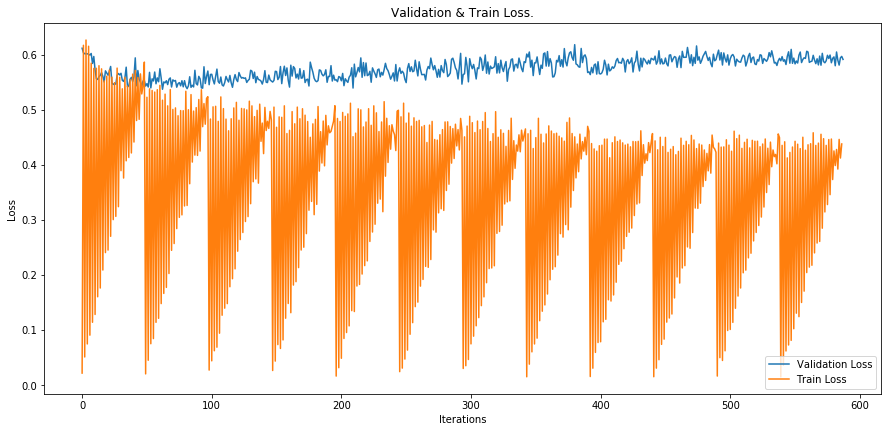

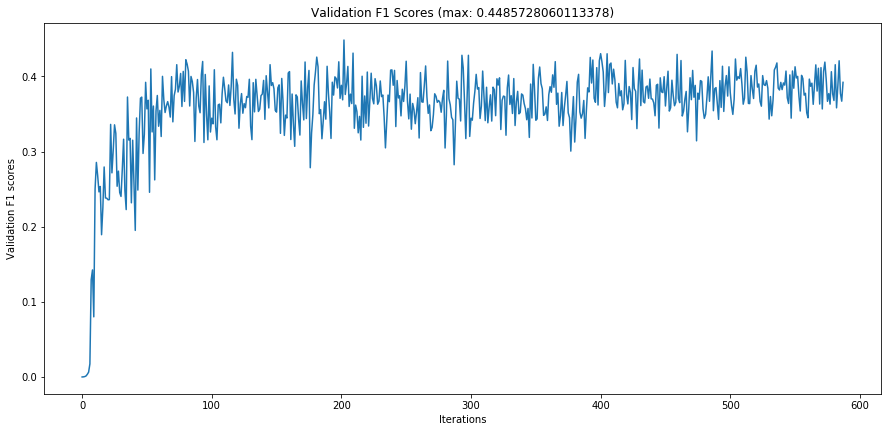

In [20]:
def plot_UNet_train_stats(train_losses, test_losses, F1_scores, best_f1, val_or_test = 'Validation'):
    train_losses = train_losses[1:]
    plt.figure(figsize=(15,15))
    ax = plt.subplot(2, 1, 1)
    if val_or_test == 'Validation':
        plt.title('Validation & Train Loss.')
    else:
        print("F1 Score: "+ str(best_f1))
        plt.title('Test Loss. F1 SCORE: '+ str(best_f1))
    plt.axis('on')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.plot(np.arange(len(test_losses)), test_losses, label=val_or_test+' Loss')
    if val_or_test == 'Validation':
        plt.plot(np.arange(len(train_losses)), train_losses, label='Train Loss')
    plt.legend()

    if val_or_test == 'Validation':
        plt.figure(figsize=(15,15))
        plt.subplot(2, 1, 2)
        plt.xlabel('Iterations')
        plt.axis('on')
        plt.xlabel('Iterations')
        plt.ylabel(val_or_test+' F1 scores')
        plt.title(val_or_test+' F1 Scores (max: '+str(best_f1)+')')
        plt.plot(np.arange(len(F1_scores)), F1_scores)
        plt.show()



    torch.cuda.empty_cache() 
plot_UNet_train_stats(train_losses, test_losses, F1_scores, best_f1=best_f1, val_or_test ='Validation')

# Notes on Loss / F1 Score Plots for Training UNet

### Since the validation loss seems to increase while the test loss decreases we could be overfitting. A possible solution would be to reduce the weighing factor for positive samples, introduce more regularization through image augmentation to 'increase' the training set size or obtain more trianing images. The loss during training is more sparadic and also much less than the validation loss which is another indication of overfitting. Since my gpu does not have enough memory I had to reduce to a small batch size which also might explain the non-smooth appearance of the loss plots. Since the training loss is fairly level it is possible the learning rate is too low however it would be necessary to smooth the plot by increasing the batch size to get a better idea because if the training loss is better fit by a linear approximation with small slope it is possible the loss is too low or instead a quick initial drop and then leveling out implying a high learning rate.

### The F1 score performs as expected and converges to ~0.80. Since we are overfitting it is likely the F1 score could be improved by reducing the tendancy to overfit with the above suggestions.

F1 Score: 0.46322738713756195


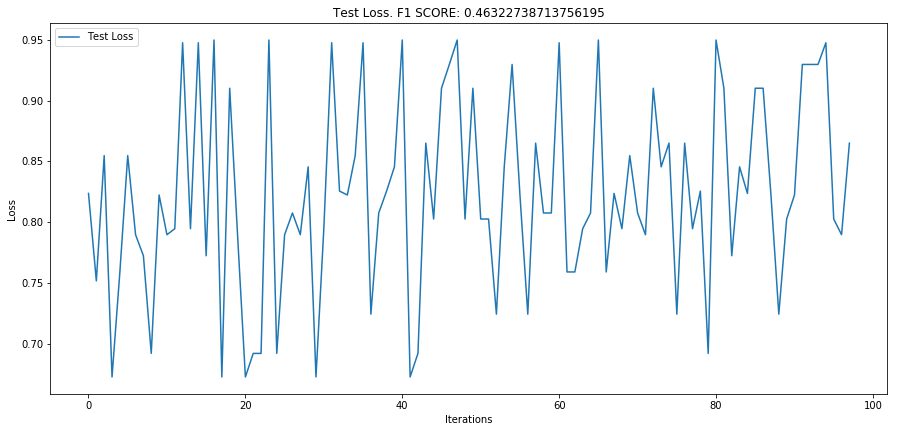

In [21]:
def test_best_model(running_best_model, image = np.array([]), load = False):
    if load:
        running_best_model = torch.load('UNet_F1_opt.pth')
    if image.any():
        given = True
        test_loader = [image, image, image]
    else:
        given = False
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)
        hand_seg = RetinaDataset(retina_array_full, with_hand_seg = True)
        
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    running_best_model.eval()
    
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([pos_weights])).to(device)
        
    test_loss, running_val_loss = 0, 0
    val_loss, running_val_loss, loss_val_norm = 0, 0, 0
    test_losses, val_imgs, val_segs, val_img_preds = [], [], [], []
    num_val = 0
    with torch.no_grad():
        for batch_idx, (image, segmentation, mask, hand_segmentation) in enumerate(hand_seg):
            segmentation = hand_segmentation
            num_val += 1
            if given:
                image, segmentation, mask = image.to(device), segmentation.to(device), mask.to(device)
                #segmentation[segmentation > 0] = 1
                #segmentation = segmentation[:,0,:,:]
            else:
                image, segmentation, mask = image.to(device), segmentation.to(device), mask.to(device)
                #segmentation[segmentation > 0] = 1
                #segmentation = segmentation[:,0,:,:]
            image = image#.permute(1,2,0)

            predicted = running_best_model(image[None])

            # only consider loss for pixels
            # within masked region
            predicted = predicted[0,:,:,:]*mask#.permute(1,2,0)
            segmentation = segmentation*mask
            #print('mask ', mask.shape, ' pred ', predicted.shape, ' image ', image.shape, ' seg ', segmentation.shape)
            #Compute Loss from forward pass
            val_loss = criterion(predicted,segmentation)#.permute(1,2,0)
            running_val_loss += val_loss.item()
            # collect sample to observe performance
            val_imgs.append(image.cpu().numpy())
            val_segs.append(segmentation.cpu().numpy())
            val_img_preds.append(predicted.cpu().numpy())
            
            test_losses.append(val_loss.item()) 
        
    F1_score = get_score_model(running_best_model,test_loader)

    
    return test_losses, val_imgs, val_segs, val_img_preds, running_val_loss, F1_score

test_sample_losses, test_imgs, test_segs, test_img_preds, running_val_loss, F1_score = test_best_model(running_best_model, load = False)
plot_UNet_train_stats(test_sample_losses, test_sample_losses, [], F1_score, 'Test')

## F1 Score on Testing Data
### The F1 score for each test image is plotted above. The accompanying Images are below along with the loss associated to that test image. The images which did poorly are those that have more variation in color. To improve this it would help to augment the images during training by adjusting RGB values randomly.

In [22]:
#Visualing a few cases in the training set
def view_UNet_preds_during_training(val_imgs, val_segs, sample_losses, val_img_preds, num_im = 20, train_or_test = 'Training', net_2 = False):
    half_max = num_im
    print("...")
    if train_or_test == 'Training':
        print("....Initial and Final Predictions During Training....")
    else:
        print("....Predictions During Testing....")
        half_max = 0
    print("...")
    
    if train_or_test == 'Training':
        for idx, image in enumerate(val_imgs):
            half_max -= 1
            if half_max > 0:
                #print(image.shape)
                plt.figure()
                plt.title("Input Image")
                plt.imshow(image.transpose((1,2,0)))
                plt.figure()
                plt.title("Segmentation ground truth")
                #print(val_img_preds[idx].shape)
                if train_or_test == 'Training' and not net_2:
                    #plt.imshow(val_segs[idx].transpose((1,2,0))[0,:,:])#.cpu().numpy())
                    plt.imshow(val_segs[idx][0,:,:])
                else:
                    plt.imshow(val_segs[idx].transpose((1,2,0))[:,:,0])
                plt.figure()
                plt.title("Predicted Segmentation W/ LOSS: "+ str(sample_losses[idx]))
                plt.imshow(val_img_preds[idx][0,0,:,:])#.cpu().numpy())
    half_max = 0
    for idx, image in enumerate(val_imgs[::-1]):
        half_max += 1
        if half_max < num_im:
            #print(image.shape)
            plt.figure()
            plt.title("Input Image")
            plt.imshow(image.transpose((1,2,0)))
            plt.figure()
            plt.title("Segmentation ground truth")
            #print(val_img_preds[idx].shape)
            if train_or_test == 'Training' and not net_2:
                plt.imshow(val_segs[idx][0,:,:])#.cpu().numpy())
                plt.figure()
                plt.title("Predicted Segmentation W/ LOSS: "+ str(sample_losses[idx]))
                plt.imshow(val_img_preds[idx][0,0,:,:])#.cpu().numpy())
            else:
                plt.imshow(val_segs[idx].transpose((1,2,0))[:,:,0])
                plt.figure()
                plt.title("Predicted Segmentation W/ LOSS: "+ str(sample_losses[idx]))
                plt.imshow(val_img_preds[idx][0,:,:])#.cpu().numpy())

# Predictions of Test Images

...
....Predictions During Testing....
...


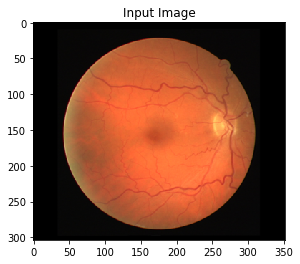

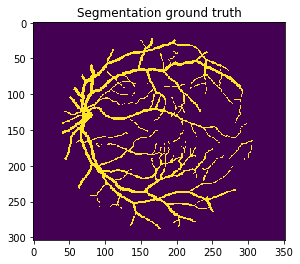

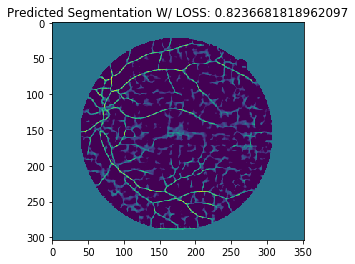

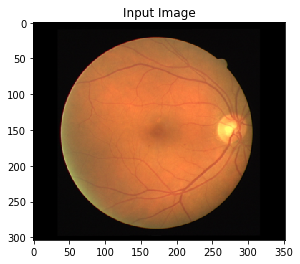

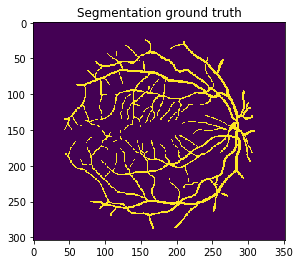

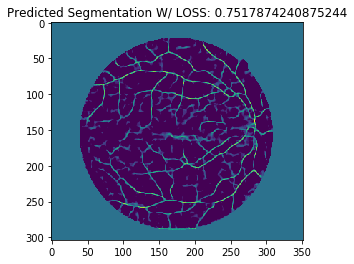

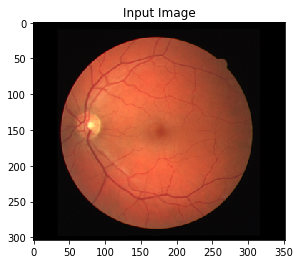

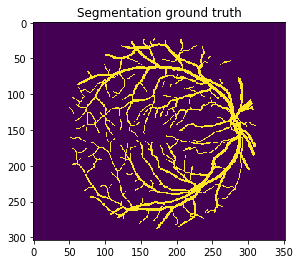

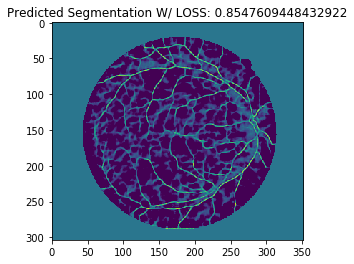

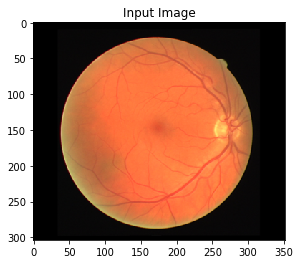

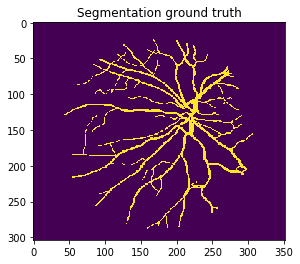

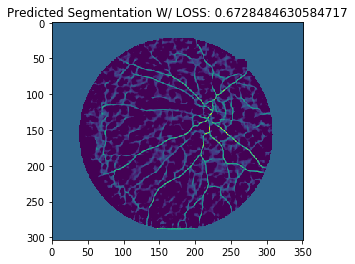

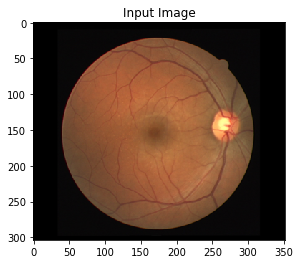

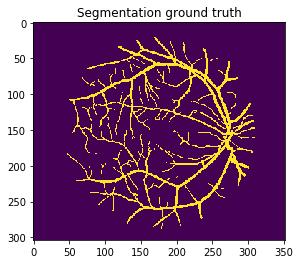

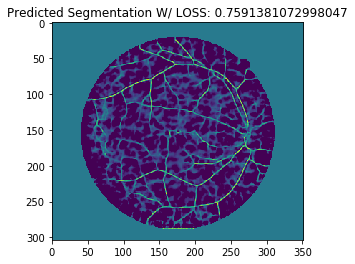

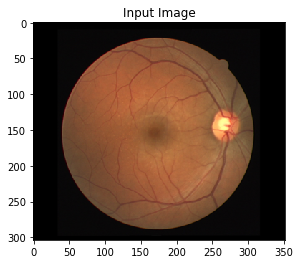

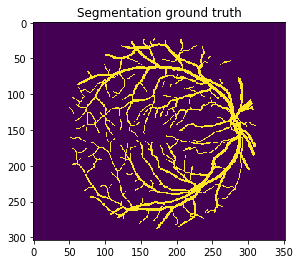

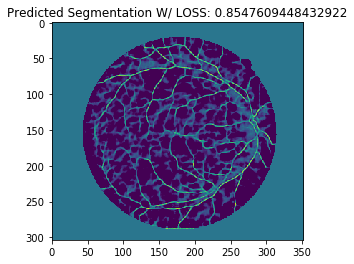

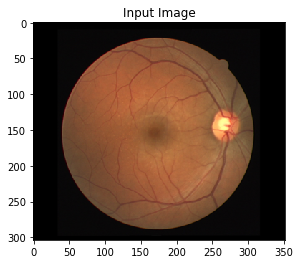

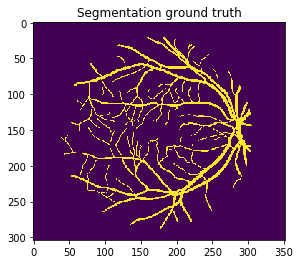

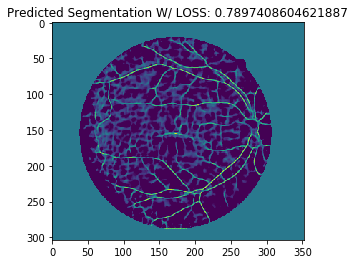

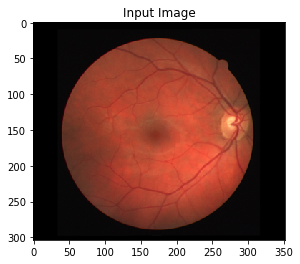

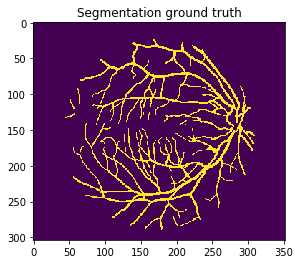

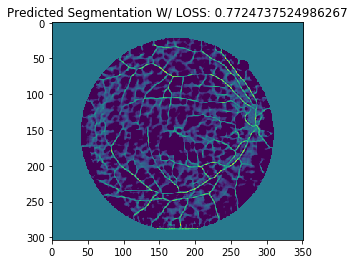

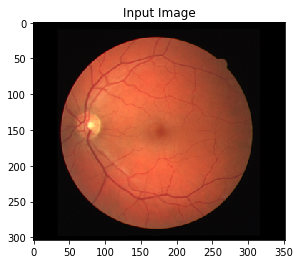

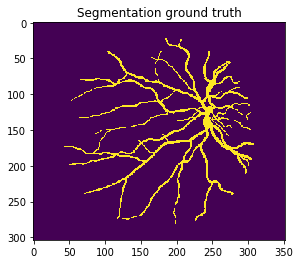

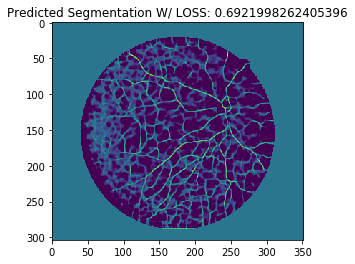

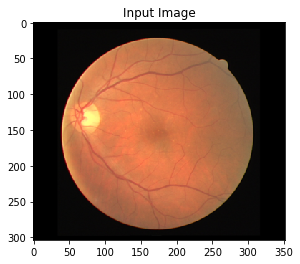

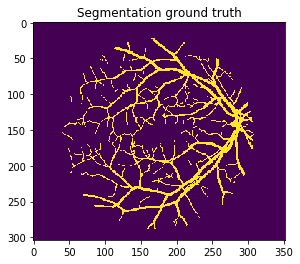

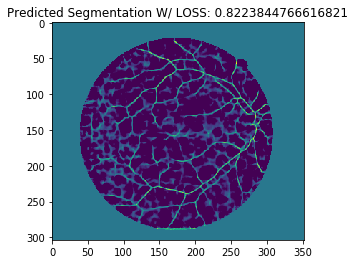

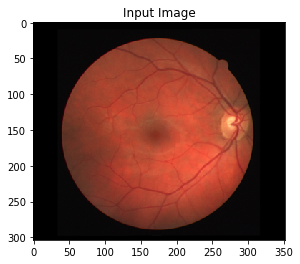

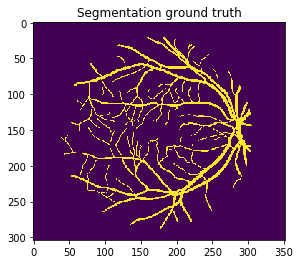

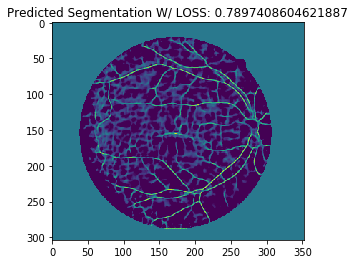

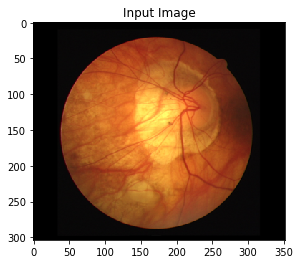

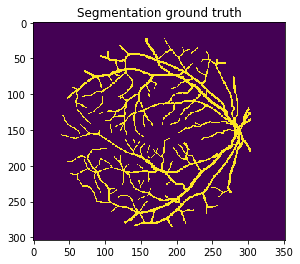

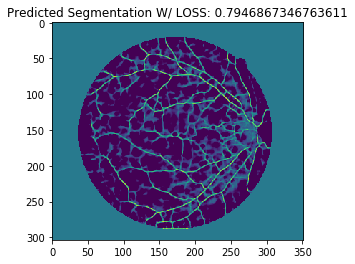

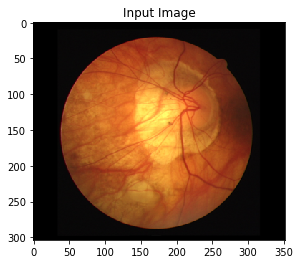

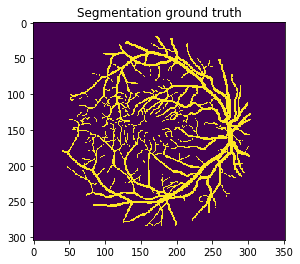

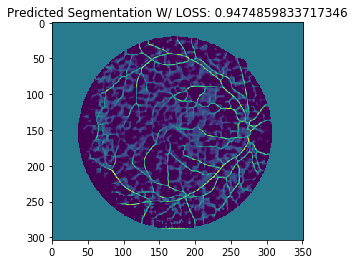

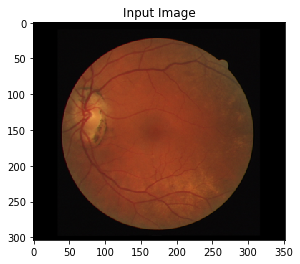

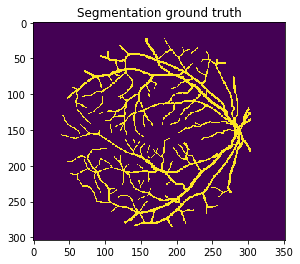

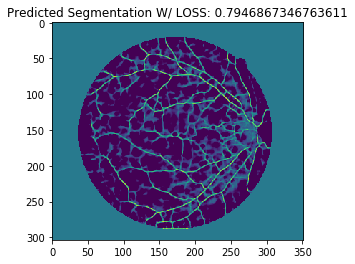

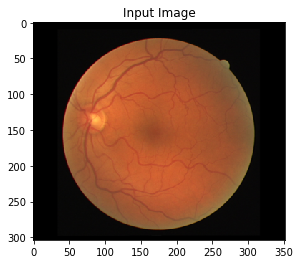

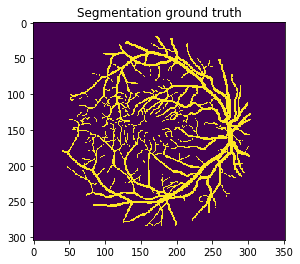

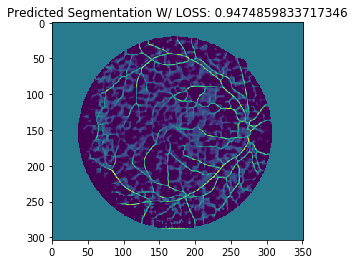

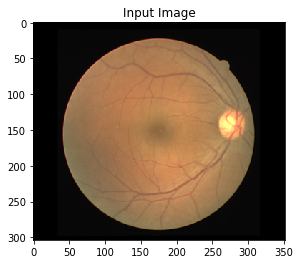

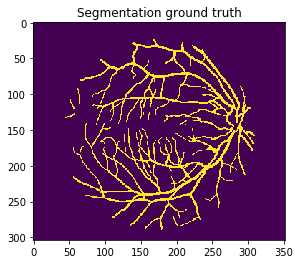

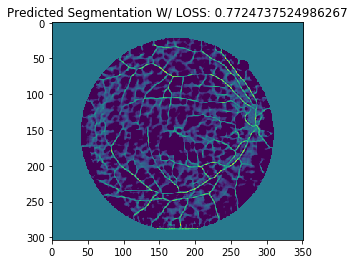

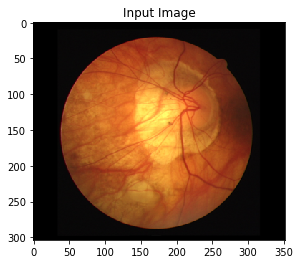

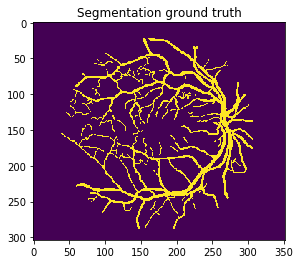

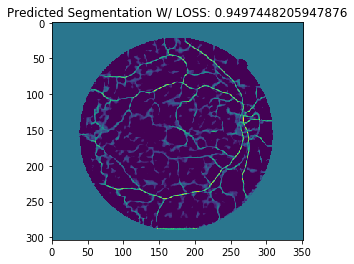

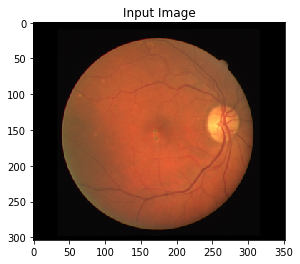

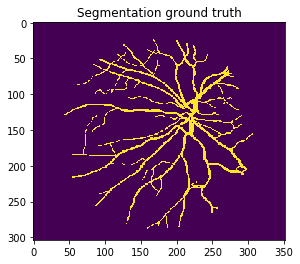

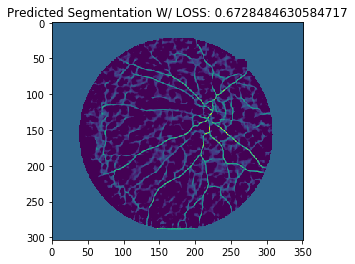

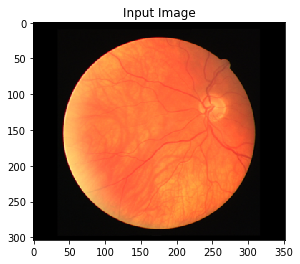

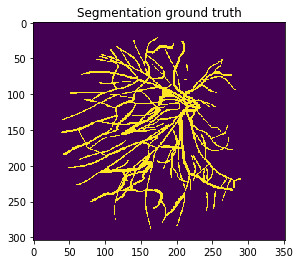

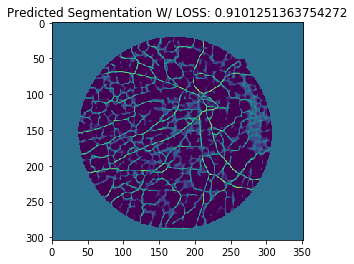

In [23]:

view_UNet_preds_during_training(test_imgs, test_segs, test_sample_losses, test_img_preds, num_im=20, train_or_test="Test" )


#### Q4 (8 points)
Visualize a few outputs of your network in the validation set and compare with your ground truth. Comment on the kinds of mistakes that you are able to distinguish.


# Predictions Sampled During Training

### The UNet seems to begin by learning the base point where the vessels converge. From there it learns the larger core structures and then into finer branches. Connected components seeem to strongly aid the identification so smaller vessels that are somewhat 'seperated' from the core structure due to image quality are harder identified. The network begins predicting blank images then the predictions begin to converge into clusters and begin forming connected components and slowly the resolution improves. Eventually, possibly due to overfitting aliasing appears and some attributes such as the iris or light fragments begin to be incorrectly incorporated into the segmentation.

...
....Initial and Final Predictions During Training....
...


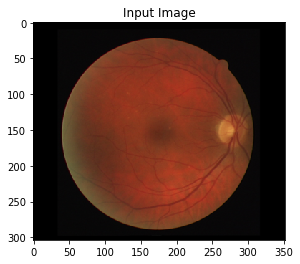

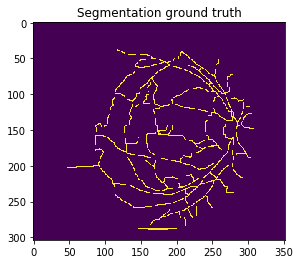

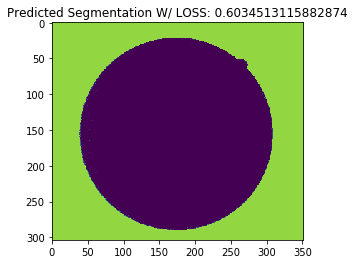

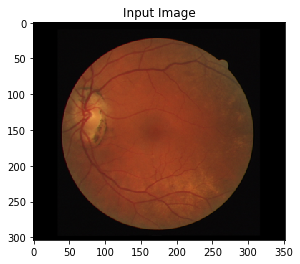

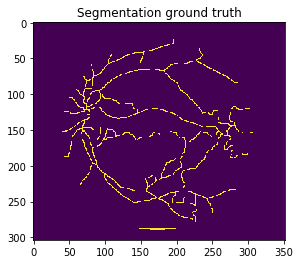

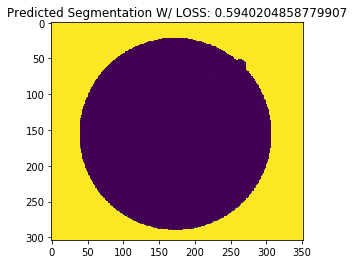

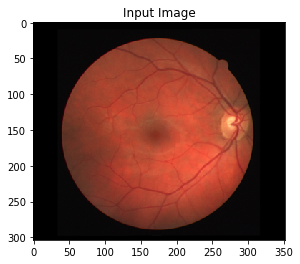

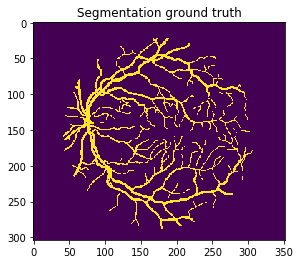

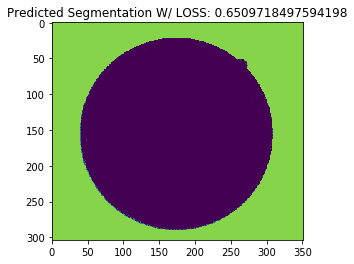

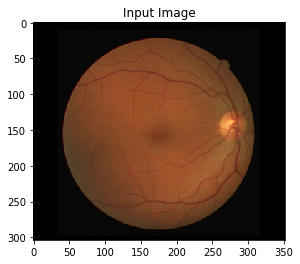

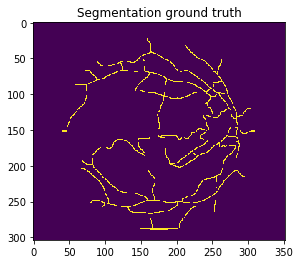

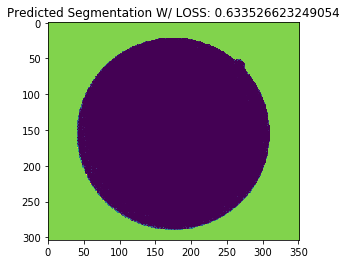

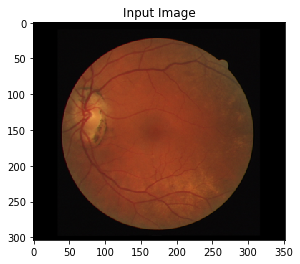

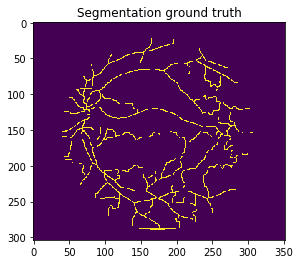

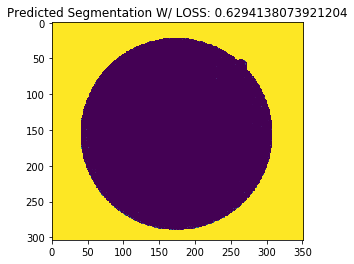

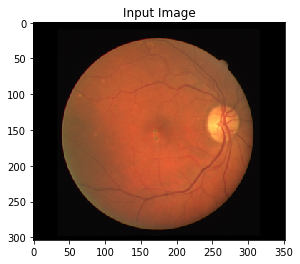

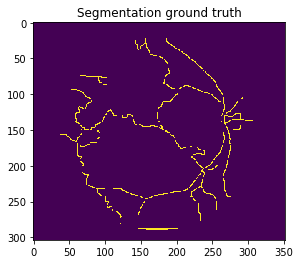

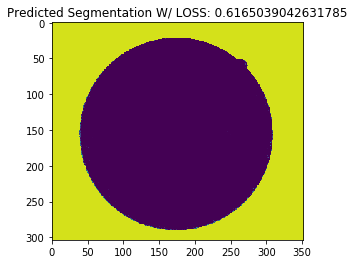

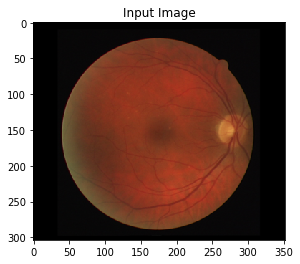

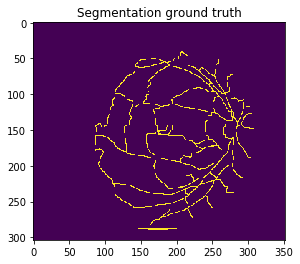

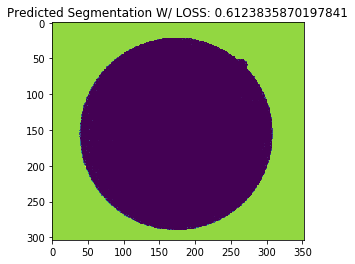

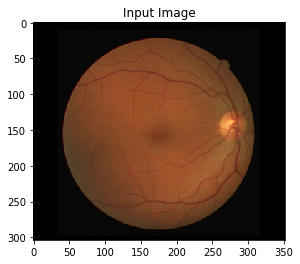

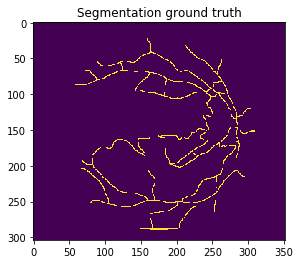

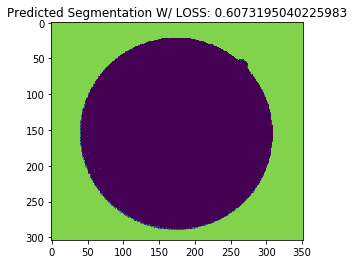

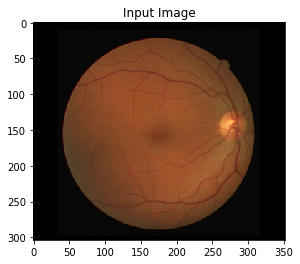

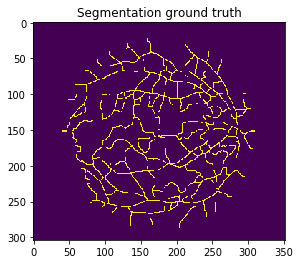

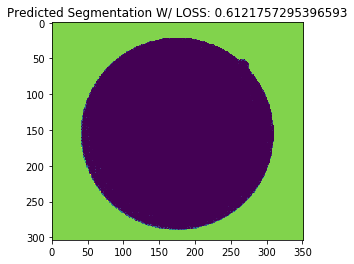

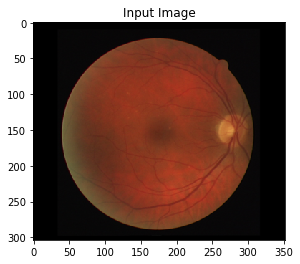

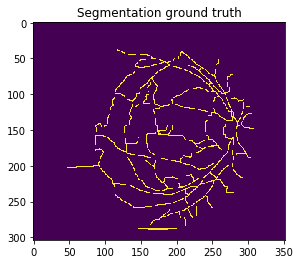

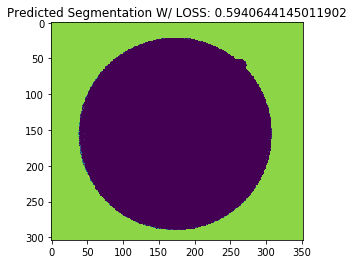

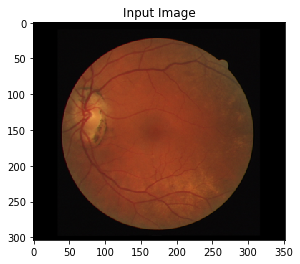

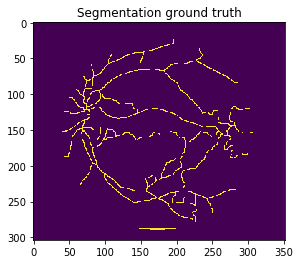

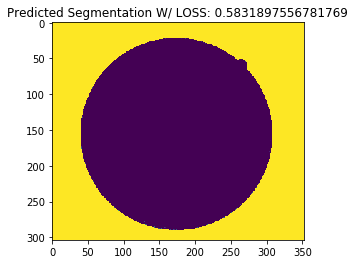

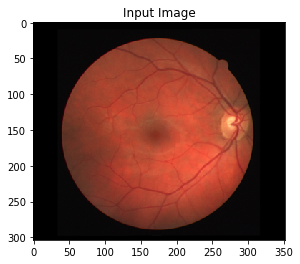

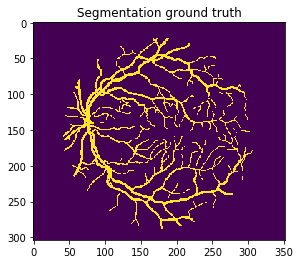

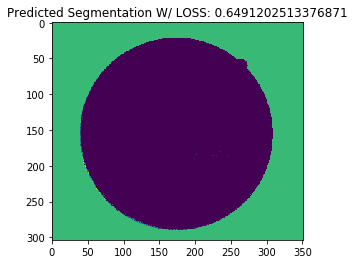

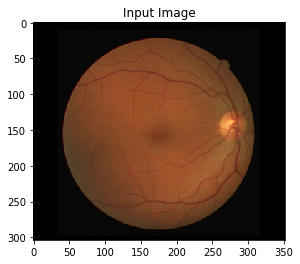

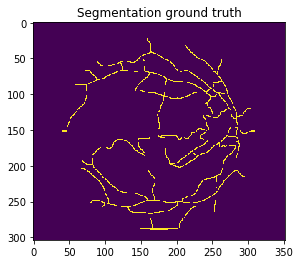

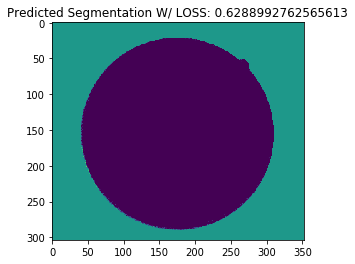

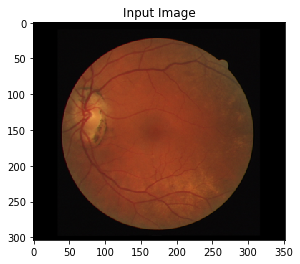

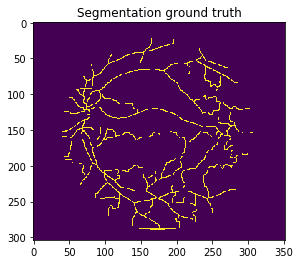

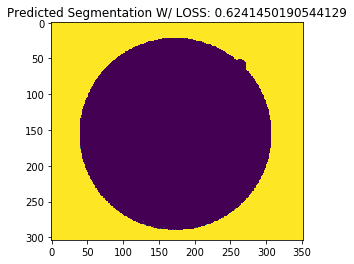

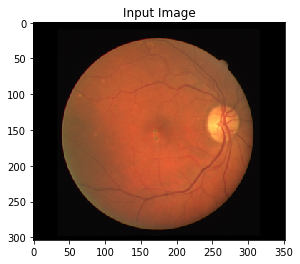

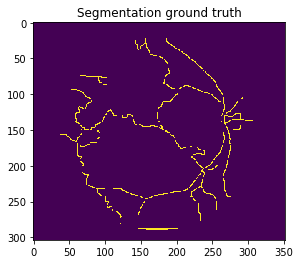

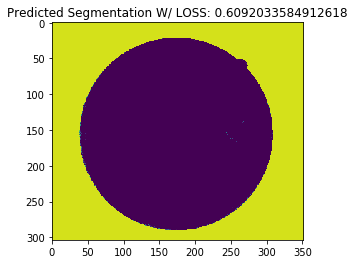

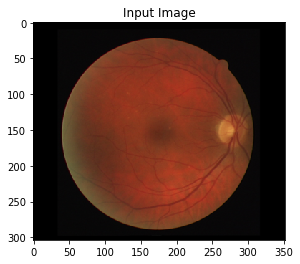

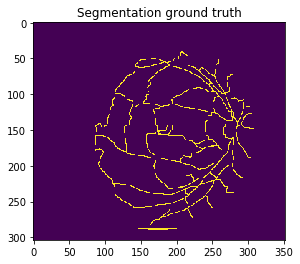

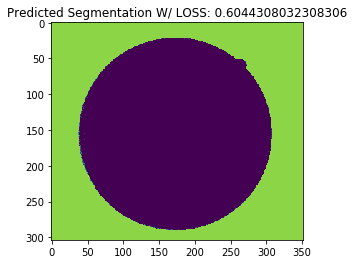

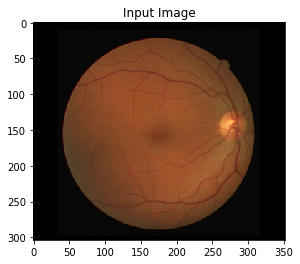

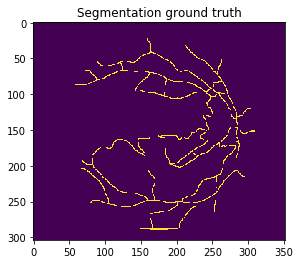

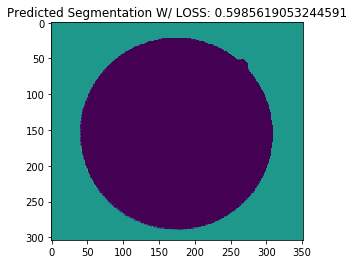

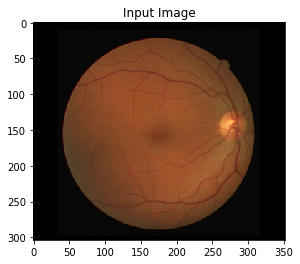

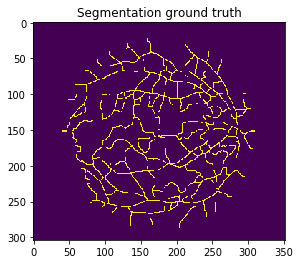

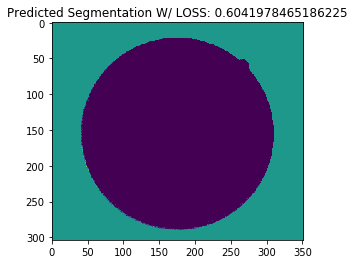

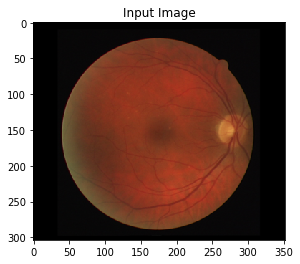

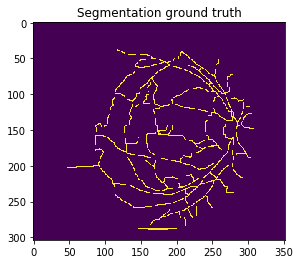

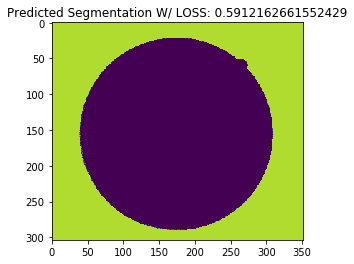

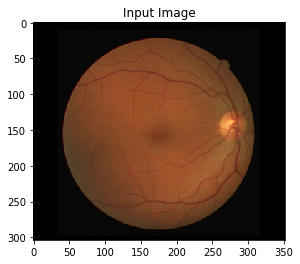

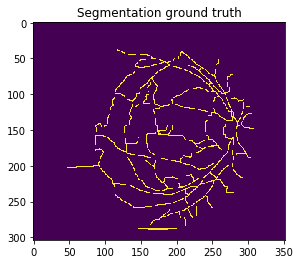

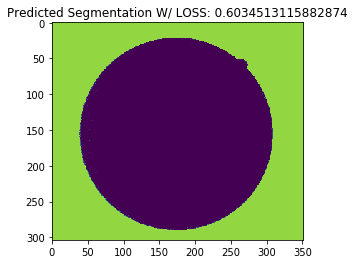

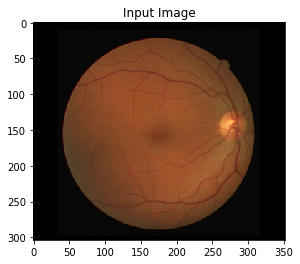

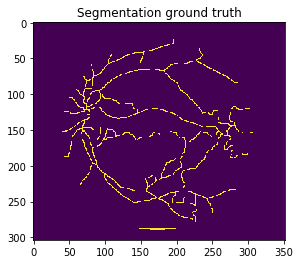

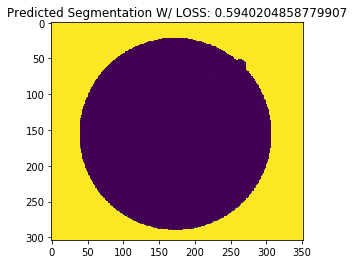

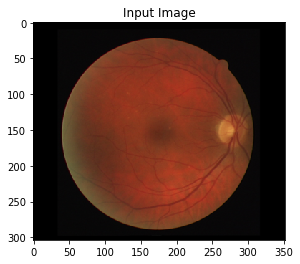

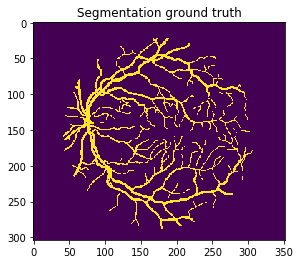

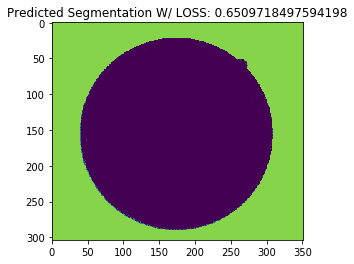

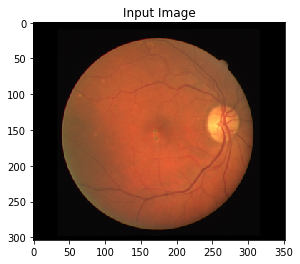

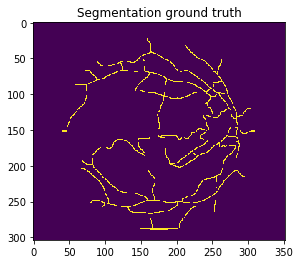

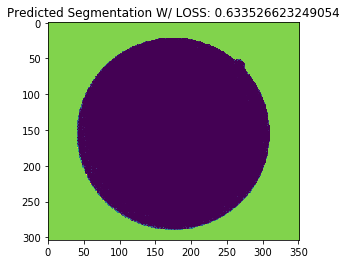

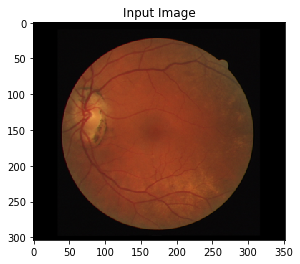

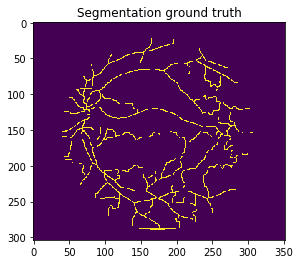

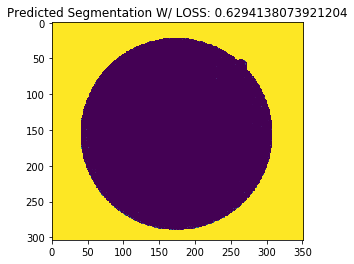

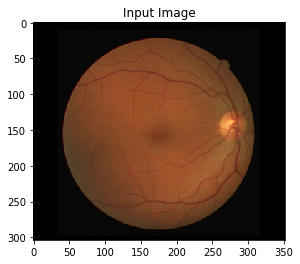

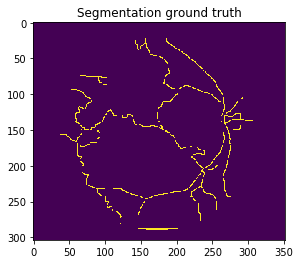

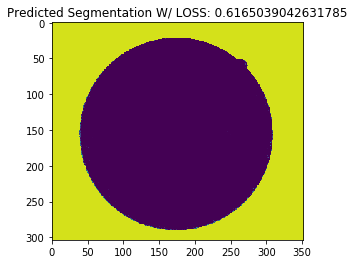

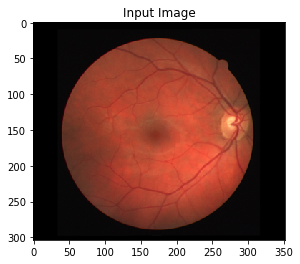

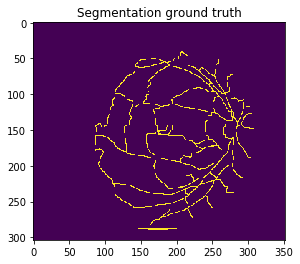

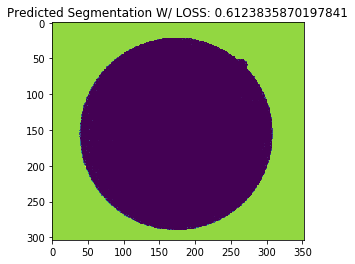

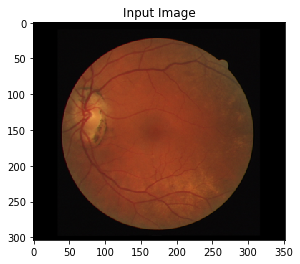

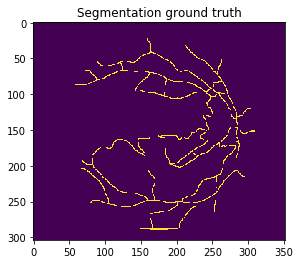

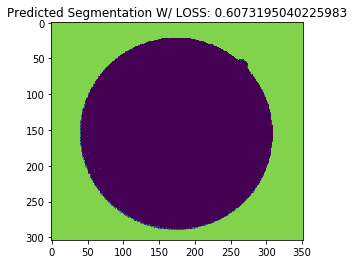

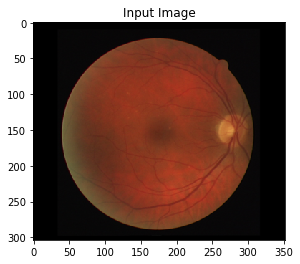

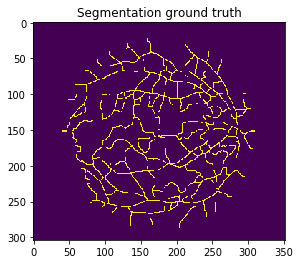

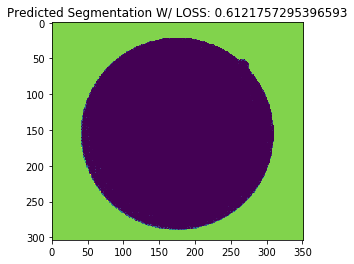

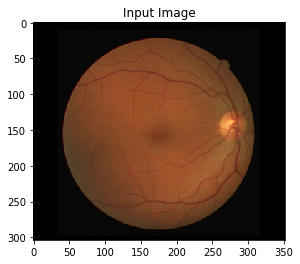

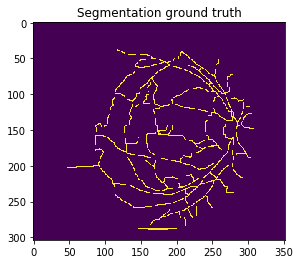

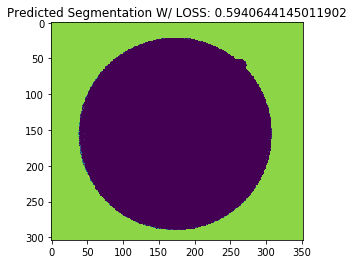

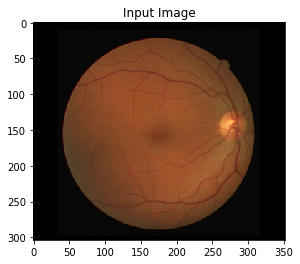

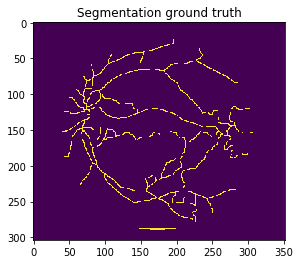

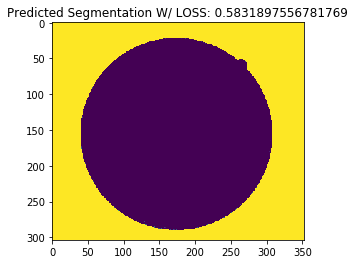

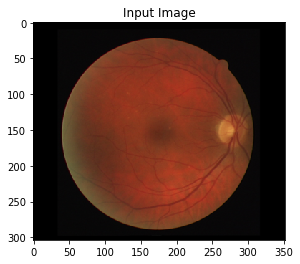

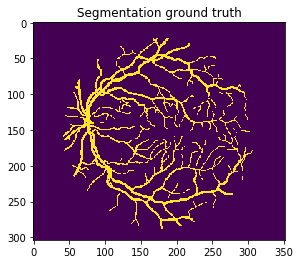

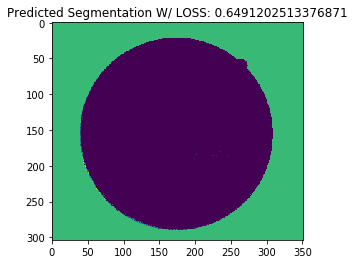

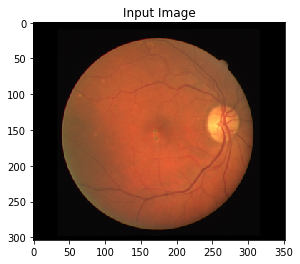

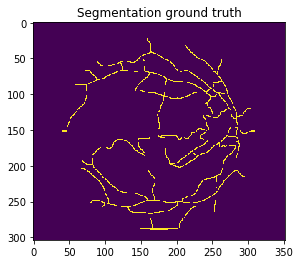

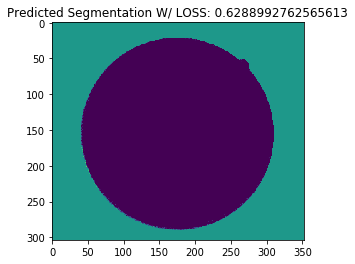

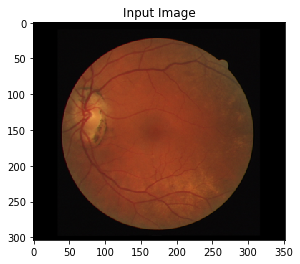

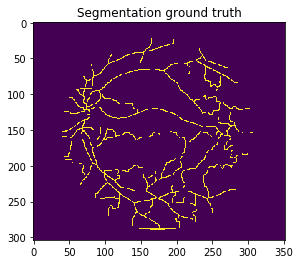

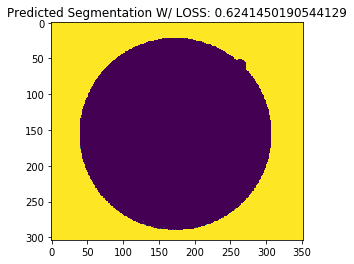

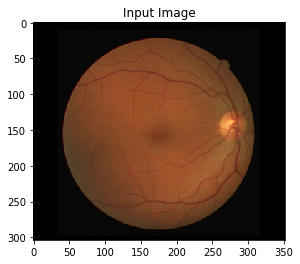

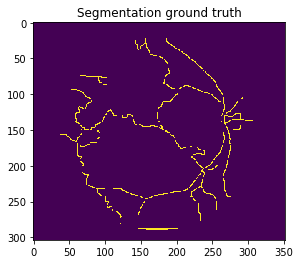

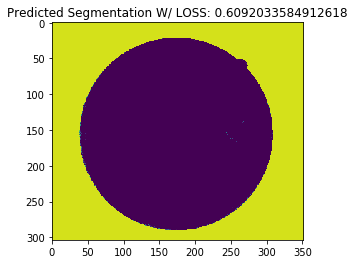

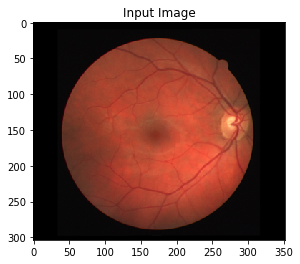

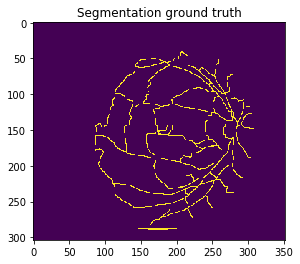

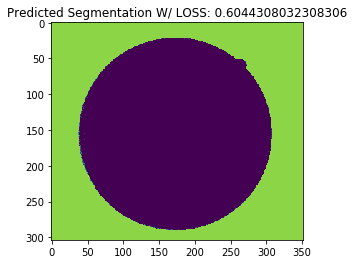

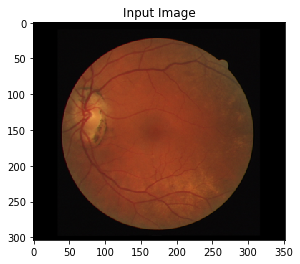

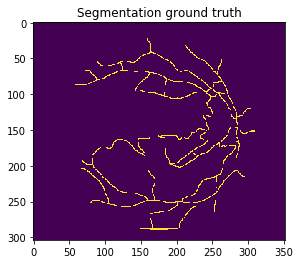

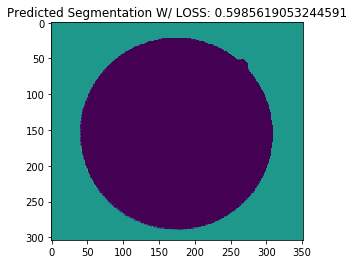

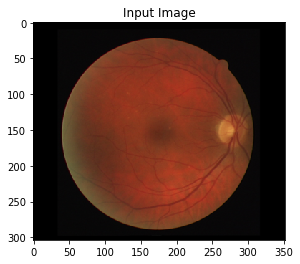

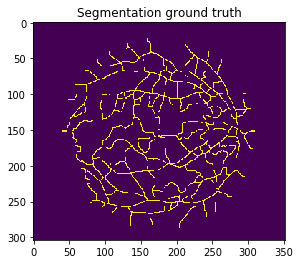

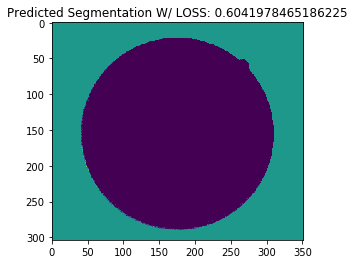

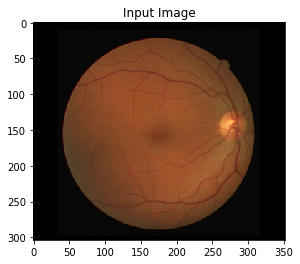

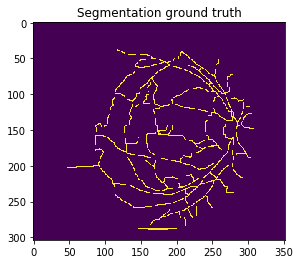

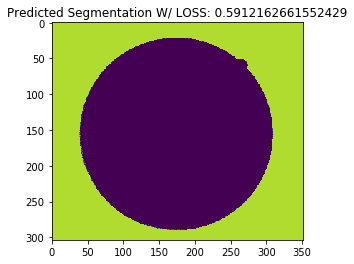

In [24]:
view_UNet_preds_during_training(val_imgs, val_segs, sample_losses, val_img_preds, train_or_test = 'Training')

#### Q5 (23 points)
Modify your u-net module to receive a boolean argument in initialization/contruction that can deactivate the use of the skip connections. To compensate for not having the extra channels coming from the skip connection, you should double the number of channels out of the upsampling layer when skip connections are deactivated. Train and test the network without the skip connections, using the hyperparameters as provided in the cell below. You should be able to get an F1 score of at least 0.5.  When compared to the network trained on Question 3, which network performs better? Explain why that happens, detailing the role of the skip connections for a segmentation task. Link your explanations to visualizations of the output of the network without skip connections.

In [25]:
def train_nonSkipNet():
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=True, num_workers=0)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

    #instantiate your model here:
    #instantiate your model here:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Instantiate Flat-Net network w/out skip connect
    FlatNet = UNetwork(in_channel = 3, out_channel = 1, skip_connect = False).to(device)

    optimizer = torch.optim.SGD(FlatNet.parameters(), lr=0.01, momentum=0.9, nesterov=True)
    n_epochs = 200
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.1)

    #train your model here:

    dataloaders = {'train': train_loader, 'val':val_loader, 'test':test_loader}  #'train': train_dataloaders,

    # Loss used allows to compensate for disproportion btwn 
    # positive and negative samples.
    criterion = torch.nn.BCEWithLogitsLoss(pos_weight = torch.FloatTensor([pos_weights])).to(device)

    steps = 0
    print_every = 50# batch_size/2.
    val_sample_rate = 15000
    train_losses, test_losses, F1_scores = [], [], []
    val_imgs, val_segs, val_img_preds, sample_losses = [], [], [], []

    test_loss = 0 

    running_best_model = copy.deepcopy(FlatNet)  
    best_loss = 1
    best_f1 = 0
    last_mark = 0
    # Loop over epochs
    FlatNet.train()
    for epoch in range(n_epochs):
        # Training
        scheduler.step() #notify lr scheduler
        running_loss = 0

        iter_count = 0

        for image, segmentation, mask in dataloaders['train']:

            steps += 1
            iter_count += 1
            image, segmentation, mask = image.to(device),segmentation.to(device), mask.to(device) # to long for pytorch loss analysis
            # Variable(val_batch.cuda(),volatile=True)
            optimizer.zero_grad() #zero gradients for forward/bakward pass

            #Forward pass with network mode l
            predicted = FlatNet(image)

            # only consider loss for pixels
            # within masked region
            predicted = predicted*mask #.permute(1,2,0)

            segmentation = segmentation*mask

            #Compute Loss from forward pass
            train_loss = criterion(predicted,segmentation) #.permute(1,2,0)

            # train update with backprop
            train_loss.backward()
            optimizer.step()
            running_loss += train_loss.item()

            if steps % print_every == 0:

                FlatNet.eval()

                test_loss, accuracy = 0, 0
                val_loss, running_val_loss, loss_val_norm = 0, 0, 0
                num_val = 0
                with torch.no_grad():
                    for image, segmentation, mask in dataloaders['val']:
                        num_val += 1
                        image, segmentation, mask = image.to(device), segmentation.to(device), mask.to(device)
                        image = image#.permute(1,2,0)

                        predicted = FlatNet(image)

                        # only consider loss for pixels
                        # within masked region
                        predicted = predicted*mask#.permute(1,2,0)
                        segmentation = segmentation*mask

                        #Compute Loss from forward pass
                        val_loss = criterion(predicted,segmentation)#.permute(1,2,0)
                        running_val_loss += val_loss.item()
                        # collect sample to observe performance
                        if steps % val_sample_rate:
                            sample_losses.append(running_val_loss/num_val)
                            val_imgs.append(image[0,:,:,:].cpu().numpy())
                            val_segs.append(segmentation[0,:,:,:].cpu().numpy())
                            val_img_preds.append(predicted.cpu().numpy())



                # get F1 score            
                val_score = get_score_model(FlatNet,dataloaders['val'])


                current_training_loss = running_loss/print_every
                current_validation_loss = running_val_loss/num_val

                train_losses.append(current_training_loss)      
                test_losses.append(current_validation_loss) 
                F1_scores.append(val_score)

                print("Epoch {epoch}/{epochs}.. ".format(epoch=epoch+1,epochs=n_epochs))
                print("Train loss: {rl}.. ".format(rl=current_training_loss)) #loss over 20 iterations

                print("Validation loss: {test_loss}.. ".format(test_loss = current_validation_loss))
                print("Validation F1: {acc}".format(acc = val_score))
                print(".....")

                #update lr if plateau in val_loss
                #plat_lr_scheduler.step(loss_val_mean/loss_val_norm) #update learning rate if validation loss plateaus


                if val_score > best_f1:# and val_score > 0.5:
                    best_f1 = val_score
                    running_best_model = copy.deepcopy(FlatNet)
                    torch.save(running_best_model, 'FlatNet_F1_opt.pth')
                # My GPU is small I need to free memory
                del train_loss
                del val_loss
                del current_training_loss
                del current_validation_loss 
                del val_score
                del predicted
                del segmentation
                del image 

                running_loss = 0

                torch.cuda.empty_cache() 

                FlatNet.train()

    print('iterations per epoch: ', iter_count) 
    torch.save(running_best_model, 'FlatNet_trained.pth')

    return train_losses, test_losses, F1_scores, best_f1, val_imgs, val_segs, sample_losses, val_img_preds, running_best_model

train_lossesNS, test_lossesNS, F1_scoresNS, best_f1NS, val_imgsNS, val_segsNS, sample_lossesNS, val_img_predsNS, running_best_modelNS = train_nonSkipNet()

Epoch 1/200.. 
Train loss: 0.6396755027770996.. 
Validation loss: 0.6324925380093711.. 
Validation F1: 0.0025331791398204746
.....
Epoch 2/200.. 
Train loss: 0.023484598398208618.. 
Validation loss: 0.6236567923000881.. 
Validation F1: 0.009516724450121417
.....
Epoch 2/200.. 
Train loss: 0.6160450899600982.. 
Validation loss: 0.6226192287036351.. 
Validation F1: 0.020182028516871783
.....
Epoch 3/200.. 
Train loss: 0.047981470823287964.. 
Validation loss: 0.6219667111124311.. 
Validation F1: 0.030603209739900394
.....
Epoch 3/200.. 
Train loss: 0.6240078175067901.. 
Validation loss: 0.6214520803519658.. 
Validation F1: 0.030301343943904952
.....
Epoch 4/200.. 
Train loss: 0.07946216702461242.. 
Validation loss: 0.6213546139853341.. 
Validation F1: 0.03146525827499965
.....
Epoch 4/200.. 
Train loss: 0.6155631029605866.. 
Validation loss: 0.6212801039218903.. 
Validation F1: 0.032214914725225724
.....
Epoch 5/200.. 
Train loss: 0.10444501757621766.. 
Validation loss: 0.6212184812341418

Epoch 33/200.. 
Train loss: 0.6064372134208679.. 
Validation loss: 0.6279423705169133.. 
Validation F1: 0.03261927313775609
.....
Epoch 34/200.. 
Train loss: 0.1881245732307434.. 
Validation loss: 0.6226287015846798.. 
Validation F1: 0.03162140942686196
.....
Epoch 34/200.. 
Train loss: 0.6164911550283432.. 
Validation loss: 0.6235259686197553.. 
Validation F1: 0.03134082477264508
.....
Epoch 35/200.. 
Train loss: 0.2064707124233246.. 
Validation loss: 0.6245107778481075.. 
Validation F1: 0.03258508327299058
.....
Epoch 35/200.. 
Train loss: 0.6230249398946762.. 
Validation loss: 0.6269578039646149.. 
Validation F1: 0.03698530933167805
.....
Epoch 36/200.. 
Train loss: 0.24114140152931213.. 
Validation loss: 0.620008430310658.. 
Validation F1: 0.03256437545785014
.....
Epoch 36/200.. 
Train loss: 0.6040416818857193.. 
Validation loss: 0.6223350209849221.. 
Validation F1: 0.03721440823327616
.....
Epoch 37/200.. 
Train loss: 0.2801409441232681.. 
Validation loss: 0.6267878455775124.. 
V

Epoch 66/200.. 
Train loss: 0.31165610313415526.. 
Validation loss: 0.6145996430090496.. 
Validation F1: 0.24558935996272827
.....
Epoch 66/200.. 
Train loss: 0.5088131713867188.. 
Validation loss: 0.6189311231885638.. 
Validation F1: 0.2502187700163288
.....
Epoch 67/200.. 
Train loss: 0.3392156374454498.. 
Validation loss: 0.6313545789037432.. 
Validation F1: 0.2157115800412316
.....
Epoch 67/200.. 
Train loss: 0.4766985058784485.. 
Validation loss: 0.6314274008784976.. 
Validation F1: 0.2304388951948543
.....
Epoch 68/200.. 
Train loss: 0.33042953968048094.. 
Validation loss: 0.6250317714044026.. 
Validation F1: 0.24800694745983498
.....
Epoch 68/200.. 
Train loss: 0.48084594309329987.. 
Validation loss: 0.6221743928534644.. 
Validation F1: 0.24971104628763277
.....
Epoch 69/200.. 
Train loss: 0.3650200802087784.. 
Validation loss: 0.6266442494732993.. 
Validation F1: 0.23521678347575709
.....
Epoch 69/200.. 
Train loss: 0.5108402919769287.. 
Validation loss: 0.6169343888759613.. 
V

Epoch 98/200.. 
Train loss: 0.4748320698738098.. 
Validation loss: 0.6355857700109482.. 
Validation F1: 0.25884361329621614
.....
Epoch 99/200.. 
Train loss: 0.44105337262153627.. 
Validation loss: 0.6258980610540935.. 
Validation F1: 0.2978030355533994
.....
Epoch 99/200.. 
Train loss: 0.4642071920633316.. 
Validation loss: 0.6422940215894154.. 
Validation F1: 0.2746446084501461
.....
Epoch 100/200.. 
Train loss: 0.42903520226478575.. 
Validation loss: 0.6453643526349749.. 
Validation F1: 0.24808043875685554
.....
Epoch 100/200.. 
Train loss: 0.48354232430458066.. 
Validation loss: 0.6466876630272184.. 
Validation F1: 0.26107607107145603
.....
Epoch 101/200.. 
Train loss: 0.4563301920890808.. 
Validation loss: 0.6377492951495307.. 
Validation F1: 0.2788321870039921
.....
Epoch 102/200.. 
Train loss: 0.015429783463478088.. 
Validation loss: 0.6612355091742107.. 
Validation F1: 0.2547854505326599
.....
Epoch 102/200.. 
Train loss: 0.45248480677604674.. 
Validation loss: 0.65299343637057

Epoch 131/200.. 
Train loss: 0.08668364822864533.. 
Validation loss: 0.6896998307534626.. 
Validation F1: 0.2514312125127365
.....
Epoch 131/200.. 
Train loss: 0.4563103038072586.. 
Validation loss: 0.673227750829288.. 
Validation F1: 0.26506277149267266
.....
Epoch 132/200.. 
Train loss: 0.10618684351444245.. 
Validation loss: 0.6685807768787656.. 
Validation F1: 0.279217716768516
.....
Epoch 132/200.. 
Train loss: 0.44430498957633974.. 
Validation loss: 0.6741961113044194.. 
Validation F1: 0.2772366752828093
.....
Epoch 133/200.. 
Train loss: 0.11786424219608307.. 
Validation loss: 0.7001517691782543.. 
Validation F1: 0.26028771472598844
.....
Epoch 133/200.. 
Train loss: 0.44476161181926727.. 
Validation loss: 0.6728306817156928.. 
Validation F1: 0.2888693110145566
.....
Epoch 134/200.. 
Train loss: 0.14340212166309357.. 
Validation loss: 0.6815427754606519.. 
Validation F1: 0.27279037023816605
.....
Epoch 134/200.. 
Train loss: 0.43719942510128024.. 
Validation loss: 0.693710158978

Epoch 163/200.. 
Train loss: 0.20031801044940947.. 
Validation loss: 0.683492334825652.. 
Validation F1: 0.2956580057107437
.....
Epoch 163/200.. 
Train loss: 0.43775968968868256.. 
Validation loss: 0.6978567902530942.. 
Validation F1: 0.2908689174259854
.....
Epoch 164/200.. 
Train loss: 0.21833037078380585.. 
Validation loss: 0.6875121572187969.. 
Validation F1: 0.2922468451203849
.....
Epoch 164/200.. 
Train loss: 0.4335097622871399.. 
Validation loss: 0.6874703850064959.. 
Validation F1: 0.30095811387007776
.....
Epoch 165/200.. 
Train loss: 0.22700416743755342.. 
Validation loss: 0.6809845588036946.. 
Validation F1: 0.31013730645632487
.....
Epoch 165/200.. 
Train loss: 0.4417237377166748.. 
Validation loss: 0.6881618989365441.. 
Validation F1: 0.2971392732863964
.....
Epoch 166/200.. 
Train loss: 0.24853358447551727.. 
Validation loss: 0.685122257896832.. 
Validation F1: 0.29742402542622276
.....
Epoch 166/200.. 
Train loss: 0.4471269512176514.. 
Validation loss: 0.67959594300815

Epoch 195/200.. 
Train loss: 0.32074513018131257.. 
Validation loss: 0.6914530545473099.. 
Validation F1: 0.29670984661845345
.....
Epoch 195/200.. 
Train loss: 0.4254944294691086.. 
Validation loss: 0.7021099030971527.. 
Validation F1: 0.28745933337425567
.....
Epoch 196/200.. 
Train loss: 0.33354535818099973.. 
Validation loss: 0.6932732803480965.. 
Validation F1: 0.29508393165636454
.....
Epoch 196/200.. 
Train loss: 0.4228328275680542.. 
Validation loss: 0.6943772243601936.. 
Validation F1: 0.3071812874802343
.....
Epoch 197/200.. 
Train loss: 0.3444485795497894.. 
Validation loss: 0.6962316461971828.. 
Validation F1: 0.2954980460961799
.....
Epoch 197/200.. 
Train loss: 0.4359625536203384.. 
Validation loss: 0.6998333824532372.. 
Validation F1: 0.287809989521481
.....
Epoch 198/200.. 
Train loss: 0.37240340232849123.. 
Validation loss: 0.7006491465227944.. 
Validation F1: 0.2896537801554457
.....
Epoch 198/200.. 
Train loss: 0.4293867611885071.. 
Validation loss: 0.697488220674651

ValueError: not enough values to unpack (expected 9, got 6)

In [ ]:
view_UNet_preds_during_training(val_imgs, val_segs, sample_losses, val_img_preds, num_im=40, net_2 = True, train_or_test = 'Training')


In [ ]:
plot_UNet_train_stats(train_lossesNS, test_lossesNS, F1_scoresNS, best_f1NS)

In [ ]:
test_sample_lossesNS, test_imgsNS, test_segsNS, test_img_predsNS, running_val_lossNS, F1_scoreNS = test_best_model(running_best_modelNS)
plot_UNet_train_stats(test_sample_lossesNS, test_sample_lossesNS, [], F1_scoreNS, 'Test')

In [ ]:

view_UNet_preds_during_training(test_imgsNS, test_segsNS, test_sample_lossesNS, test_img_predsNS, num_im=20, train_or_test="Test", net_2 = True)
